<a href="https://colab.research.google.com/github/saritmaitra/Momentum_Trading/blob/main/Portfolio_Management_Of_Multiple_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***How do we distribute capital among the different strategies and instruments in order to maximise the return and minimise the risk?***

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import warnings
# import seaborn as sns

# plt.style.use('seaborn')
# sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
# plt.rcParams['figure.figsize'] = [15, 6]
# plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip install yfinance
import yfinance as yf
import datetime as dt
import matplotlib.transforms as transform
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None
pd.set_option('use_inf_as_na', True)
# Install it again from its github repo
!pip install pyfolio
import pyfolio as pf

import pandas as pd
import numpy as np
import datetime
import math
from tabulate import tabulate
import cvxopt as opt
from cvxopt import blas, solvers
import cvxpy as cp

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


# **Asset Allocation** 
Evaluating the performance of a basic 1/n portfolio

To have a benchmark with which to compare our optimization we will start from the simple portfolio distributing the same weight for each of its elements.

For the optimization of weights in the capital distribution, there are numerous academic studies, each one trying to optimize different parameters.

Two of the best known and diametrically opposed methods are:

- The efficient frontier proposed by Markowitz in which we try to maximize the return with a certain risk, i.e. it focuses on containing the assigned risk.
- Kelly's method proposed by John Kelly and Ed Thorpe that tries to maximise the expectation of the log utility of wealth, i.e. maximizing return is the focus.

[*********************100%***********************]  8 of 8 completed
Downloaded 755 rows of data.
                  BPMC         DIS  ...       SGRY           Z
Date                                ...                       
2018-01-02   80.010002  108.726067  ...  13.350000   42.480000
2018-01-03   84.010002  109.192856  ...  12.900000   42.970001
2018-01-04   78.550003  109.144241  ...  12.900000   42.130001
2018-01-05   77.739998  108.551003  ...  12.650000   42.610001
2018-01-08   74.639999  106.994995  ...  13.150000   42.759998
...                ...         ...  ...        ...         ...
2020-12-23  124.480003  173.550003  ...  28.020000  141.229996
2020-12-24  123.000000  173.729996  ...  27.820000  138.639999
2020-12-28  122.449997  178.860001  ...  28.010000  132.679993
2020-12-29  116.669998  177.300003  ...  28.889999  130.559998
2020-12-30  115.000000  181.169998  ...  28.219999  130.449997

[755 rows x 8 columns]


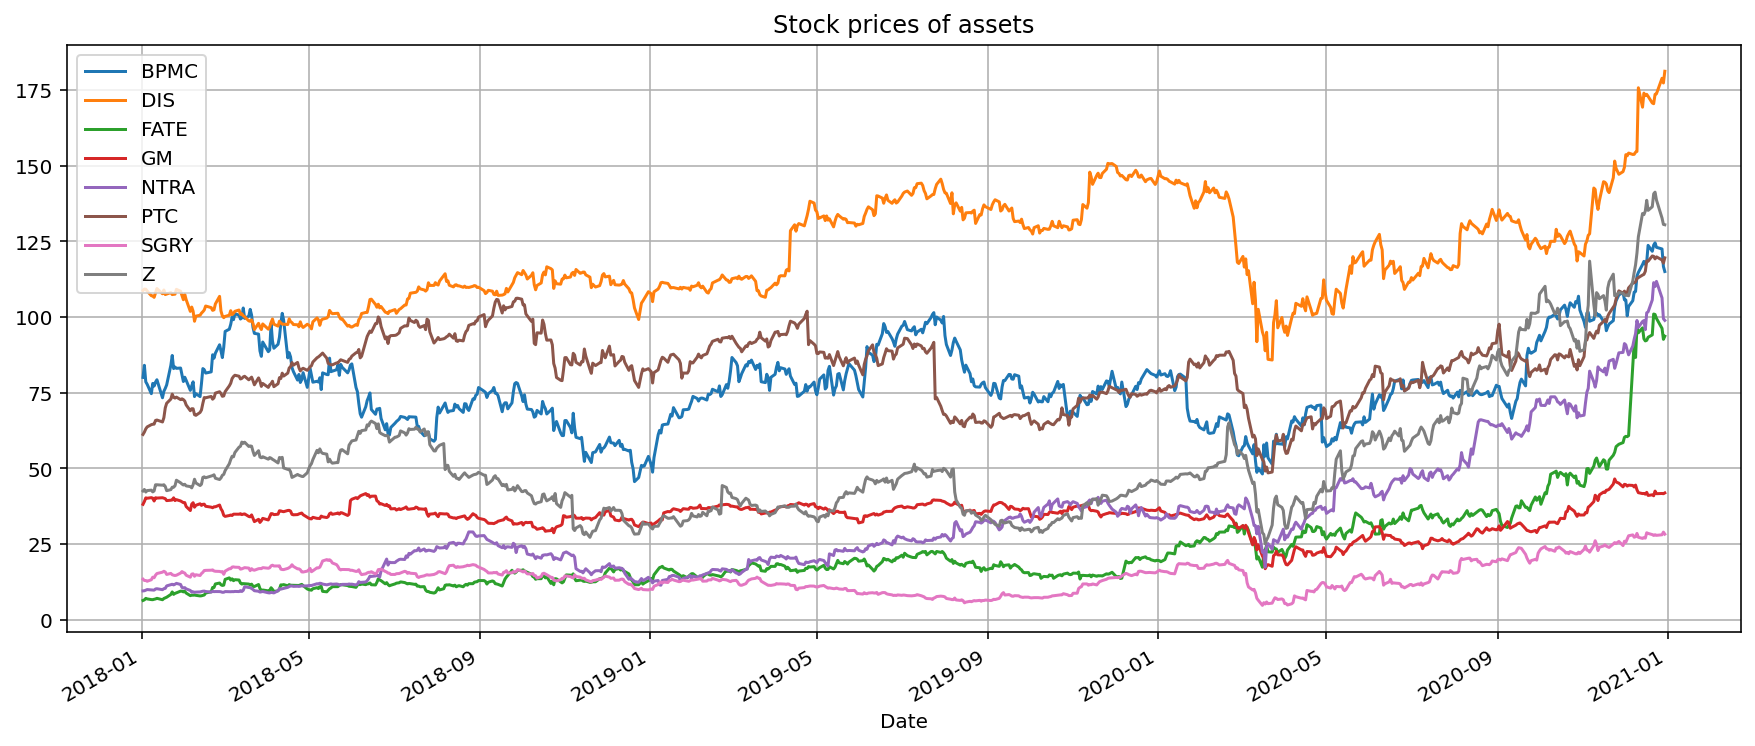

In [2]:
tickers=["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]
start = dt.datetime(2018,1,1)
end = dt.datetime(2020,12,31) # dt.datetime.now()

def portfolio():
  prices = yf.download(tickers, start=start, 
                      end=end, adjusted=True,
                      index_col='Date',
                      parse_dates=True)
  print(f'Downloaded {prices.shape[0]} rows of data.')
  df = prices['Adj Close']
  return (df)
  # print(df); print()

data = portfolio()
print(data)

data.plot(title='Stock prices of assets', figsize= (15,6))
plt.grid(True)
plt.show()

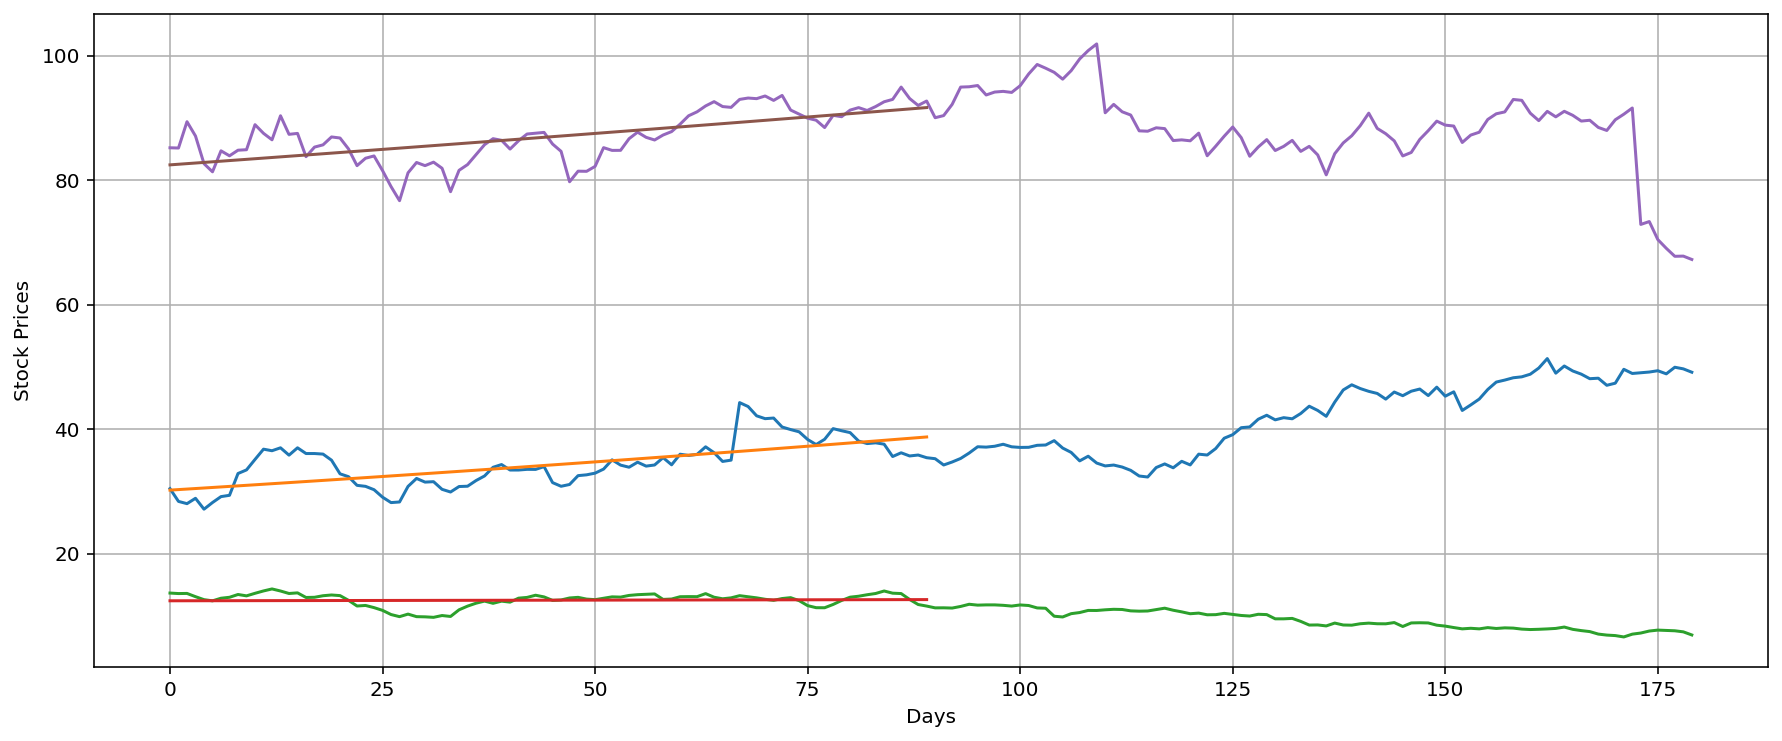

In [3]:
from scipy.stats import linregress

def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

# apply a rolling 90 day momentum calculation to all of the stocks in our universe:
momentums = data.copy(deep=True)
for Ticker in tickers:
    momentums[Ticker] = data.rolling(90).apply(momentum, raw=False)

# Let’s look at the 3 stocks with the best momentum values and plot them along with their regression curve.
plt.figure(figsize=(15, 6))
plt.xlabel('Days')
plt.ylabel('Stock Prices')

bests = momentums.max().sort_values(ascending=False).index[:3]
for best in bests:
    end = momentums[best].index.get_loc(momentums[best].idxmax())
    rets = np.log(data[best].iloc[end - 90 : end])
    x = np.arange(len(rets))
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    plt.plot(np.arange(180), data[best][end-90:end+90])
    plt.plot(x, np.e ** (intercept + slope*x))
    plt.grid(True)

                BPMC       DIS      FATE  ...       PTC      SGRY         Z
Date                                      ...                              
2019-01-02  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
2019-01-03 -0.048456 -0.024227 -0.028086  ... -0.045898 -0.014881 -0.014168
2019-01-04  0.044939  0.005873  0.092387  ... -0.004028  0.091270  0.014827
2019-01-07  0.192653  0.014591  0.223208  ...  0.007202  0.149802  0.016474
2019-01-08  0.221571  0.022483  0.269032  ...  0.026611  0.196429  0.046458

[5 rows x 8 columns]


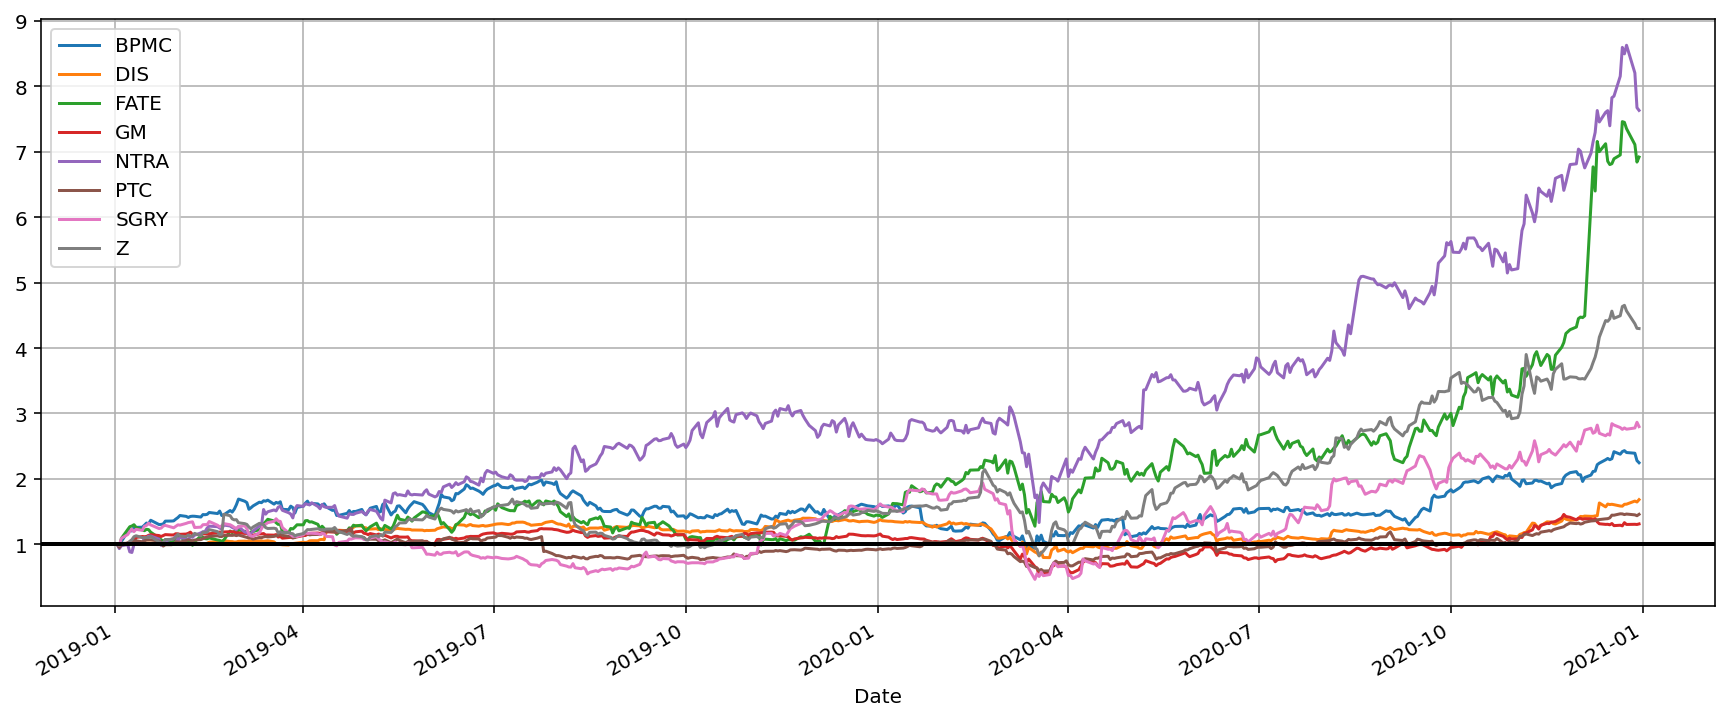

In [4]:
df = data['2019-01-01':]
returns = df.apply(lambda x: x/x[0])
print(returns.head()-1)

returns.plot(grid=True, figsize= (15,6)).axhline(y=1, color="black", lw=2)
plt.show()

We can now see how profitable BPMC, FATE, SGRY, NTRA was since the beginning of 2019. Furthermore, we see that these stocks are highly correlated; they generally move in the samedirection.

The advantage of using log differences is that, this difference can be interpreted as the percentage change in a stock but does not depend on the denominator of a fraction. 

Additionally, log differences have a desirable property: 
- the sum of the log differences can be interpreted as the total change (as a percentage) over the period summed (which is not a property of the other formulations; they will overestimate growth). 
- Log differences also more cleanly correspond to how stock prices are modeled in continuous time.

                BPMC       DIS      FATE  ...       PTC      SGRY         Z
Date                                      ...                              
2019-01-02       NaN       NaN       NaN  ...       NaN       NaN       NaN
2019-01-03 -0.049670 -0.024525 -0.028488  ... -0.046985 -0.014993 -0.014269
2019-01-04  0.093629  0.030381  0.116853  ...  0.042949  0.102335  0.028988
2019-01-07  0.132222  0.008630  0.113111  ...  0.011213  0.052247  0.001622
2019-01-08  0.023957  0.007748  0.036778  ...  0.019087  0.039752  0.029071

[5 rows x 8 columns]


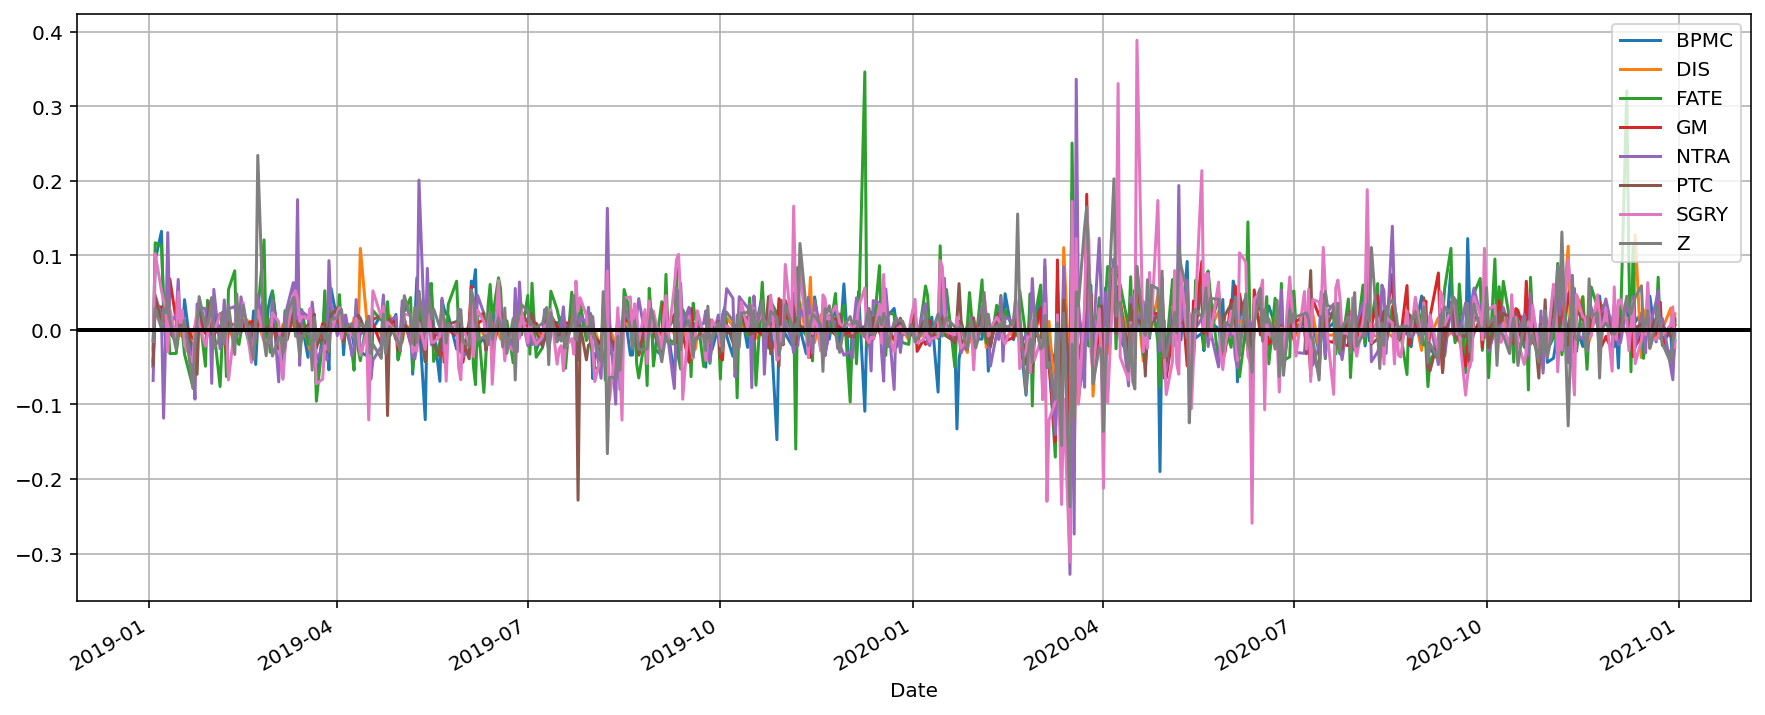

In [5]:
price_change = df.apply(lambda x: np.log(x) - np.log(x.shift(1)))
print(price_change.head())

price_change.plot(grid=True, figsize = (15,6)).axhline(y=0, color="black", lw=2)
plt.show()

Looking at returns since the beginning of 2019 make the overall trend of the stocks much more apparent. Changes between days, though, are what more advanced methods actually consider when modelling the behavior of a stock. so they should not be ignored.

From what we have so far we can already compute informative metrics for our stocks, which can be considered some measure of risk.

First, we will want to annualize our returns, thus computing the annual percentage rate. This helps us keep returns on a common time scale.

In [6]:
ann_price_change = price_change * 252 * 100
# Considering 252 trading days in a year
print(ann_price_change.tail())

                   BPMC         DIS  ...        SGRY            Z
Date                                 ...                         
2020-12-23   154.328069  454.199236  ...  207.705470   101.910814
2020-12-24  -301.410447   26.121953  ... -180.517219  -466.429215
2020-12-28  -112.936242  733.346082  ...  171.521832 -1107.300150
2020-12-29 -1218.504101 -220.755781  ...  779.534177  -405.903616
2020-12-30  -363.315778  544.132930  ... -591.307196   -21.240685

[5 rows x 8 columns]



## **Efficient Portfolios**
An efficient portfolio is defined as a portfolio with minimal risk for a given return, or, equivalently, as the portfolio with the highest return for a given level of risk.

When we only have one strategy managing one instrument, portfolio management is limited to maximizing return while minimizing risk. This would be the simplest portfolio, but not a simple solution because we have to answer some questions.
- Can we achieve the desired return with the instrument we are working with?
- Are there other instruments that allow us to achieve a higher return with the same risk or less risk with the same return?

On the other hand, if we want to diversify the portfolio and therefore reduce the risk associated with the strategy or instrument, we must build a portfolio with different instruments and ideally different strategies that capture different market regimes.

Therefore, in addition to the above questions, to achieve the required objective (Max return vs Min risk) we need to answer: 
- what weight we assign to each strategy 
- what weight we give to each instrument within the portfolio 

## **Portfolio's Elements**
Let's define the portfolio's elements which we have some control over them:

- **Capital:** The amount of money we have available to invest or speculate.
- **Instruments:** These are the assets available for inclusion in our portfolio management strategy.
- **Currency:** The currency in which the asset is traded. When we invest in an asset denominated in a foreign currency, we assume the foreign exchange risk.
- **Volatility:** Also called asset risk, indicates the movement of the asset for the period analysed.
- **Cost:** Amount of money needed to buy/sell-short an asset.
- **Liquidity:** It is the capacity of the asset to absorb our operations.
- **Rules:** These are the strategies that try to take advantage of some market regime.
- **Position weight:** The amount of capital we allocate to each asset and/or strategy.
- **Return:** Absolute returns are the return of our portfolio and relative returns are the return of our portfolio compared to a benchmark. When we are not comparing our returns with anybody, absolute return is a good measure, but when we need to compare performances we use the relative return.
- **Risk or Volatility:** This is the (estimated) amount that the portfolio assumes.

## **Portfolio performance measures**

Some of the comon Portfolio performance measures are:

- Annualised Returns
- Annualised Volatility
- Sharpe Ratio
- Sortino Ratio
- Beta
- Treynor Ratio
- Information Ratio
- Skewness
- Kurtosis
- Maximum Drawdown
- Number of Trades
- Profit ratio
- Holding period

## **Building a simple portfolio**
To build our example portfolio I have used some random instruments.

- Strategy 1 - The first strategy, that we will call A, is a trend follower system and as it's typical in these strategies, it has a positive bias.
- Strategy 2 - The second strategy, that we will call B, is a mean reversion system and as it's typical in these strategies, it has a negative bias.

## **Role of Bias**
The bias or skew is an important concept to characterize the behaviour of the strategy, as it is an indicator of the returns' distribution.

***Positive Bias:*** When we have a positive bias it means that we are having small frequent losses but we capture the infrequent outliers of the distribution. This behaviour is typical of a trend following system since we have frequent false signals with small losses and infrequent large returns, or cuts losses quickly and lets the gains run.

***Negative Bias:*** When we have a negative bias it means that we are having small frequent gains and occasional large losses. This behaviour is typical of mean reversion, arbitrage, sell options or similar systems, i.e. we have a system that systematically collects small profits and throws infrequent large losses.

## **Strategies to be used**
Here we will work directly with the returns strategies.

Any strategy that is considered to be part of the portfolio has had to pass backtesting to assess the viability of a trading strategy using historical data. If backtesting works, we may have the confidence to employ it going forward.

So, when we are satisfied with back-testing, and if we have a portfolio of multiple stocks as in this case, the next hypothesis to maximize the return and minimize the risk and to do so, we have to distribute capital among the different strategies in order of priority. 

## **About the instruments or assets**
Our assets are the main elements of a portfolio and their characteristics are decisive for obtaining the determined risk/benefit ratio. Some of the most important characteristics are:

- Currency
- Volatility
- Liquidity
- Cost
- Commission
- Slippage
- Correlation (in relation to other assets)

## **Strategy A - Trend following system - BPMC**

In [7]:
df = df [['BPMC', 'NTRA', 'SGRY']]
print(df)

                  BPMC        NTRA       SGRY
Date                                         
2019-01-02   51.180000   12.950000  10.080000
2019-01-03   48.700001   12.100000   9.930000
2019-01-04   53.480000   12.680000  11.000000
2019-01-07   61.040001   12.900000  11.590000
2019-01-08   62.520000   11.460000  12.060000
...                ...         ...        ...
2020-12-23  124.480003  110.040001  28.020000
2020-12-24  123.000000  111.739998  27.820000
2020-12-28  122.449997  106.260002  28.010000
2020-12-29  116.669998   99.389999  28.889999
2020-12-30  115.000000   98.849998  28.219999

[504 rows x 3 columns]


## **Trend following system — BPMC:**

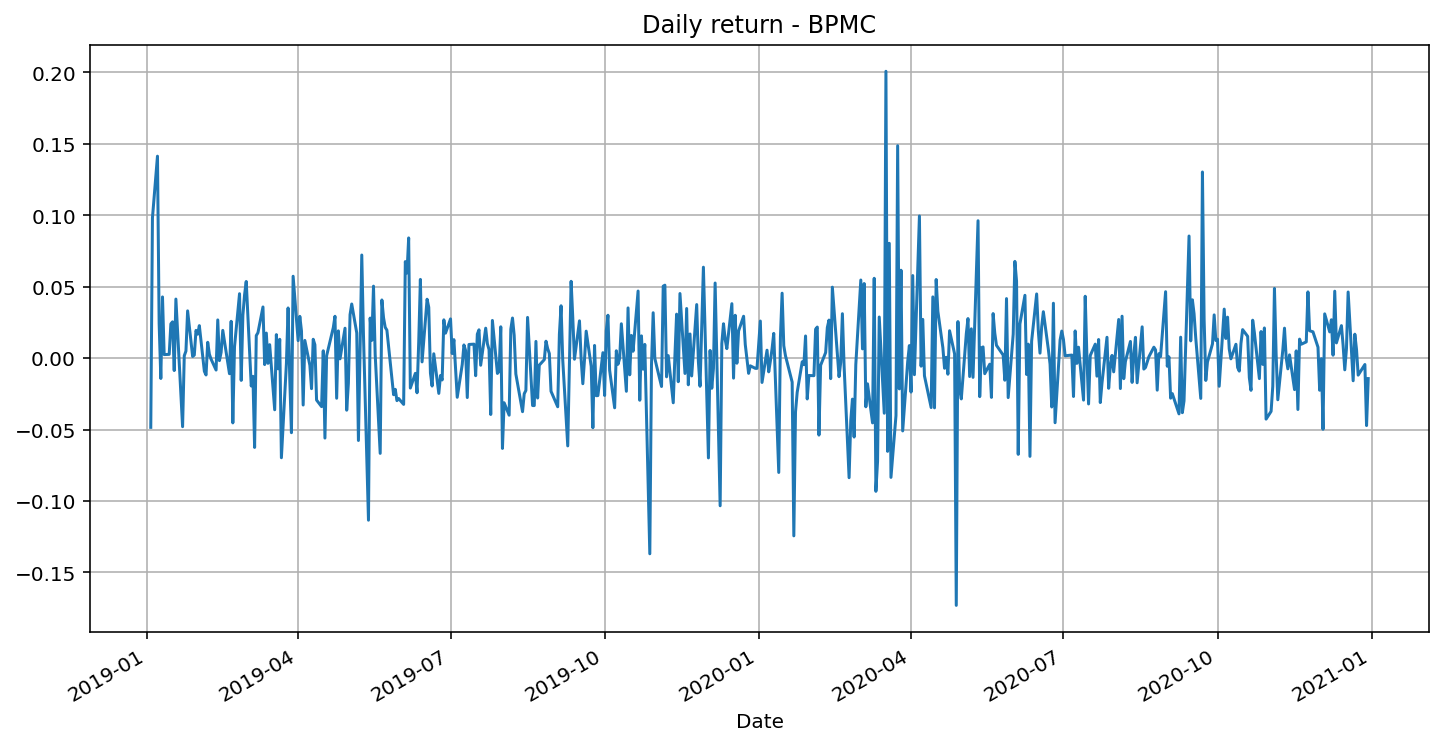

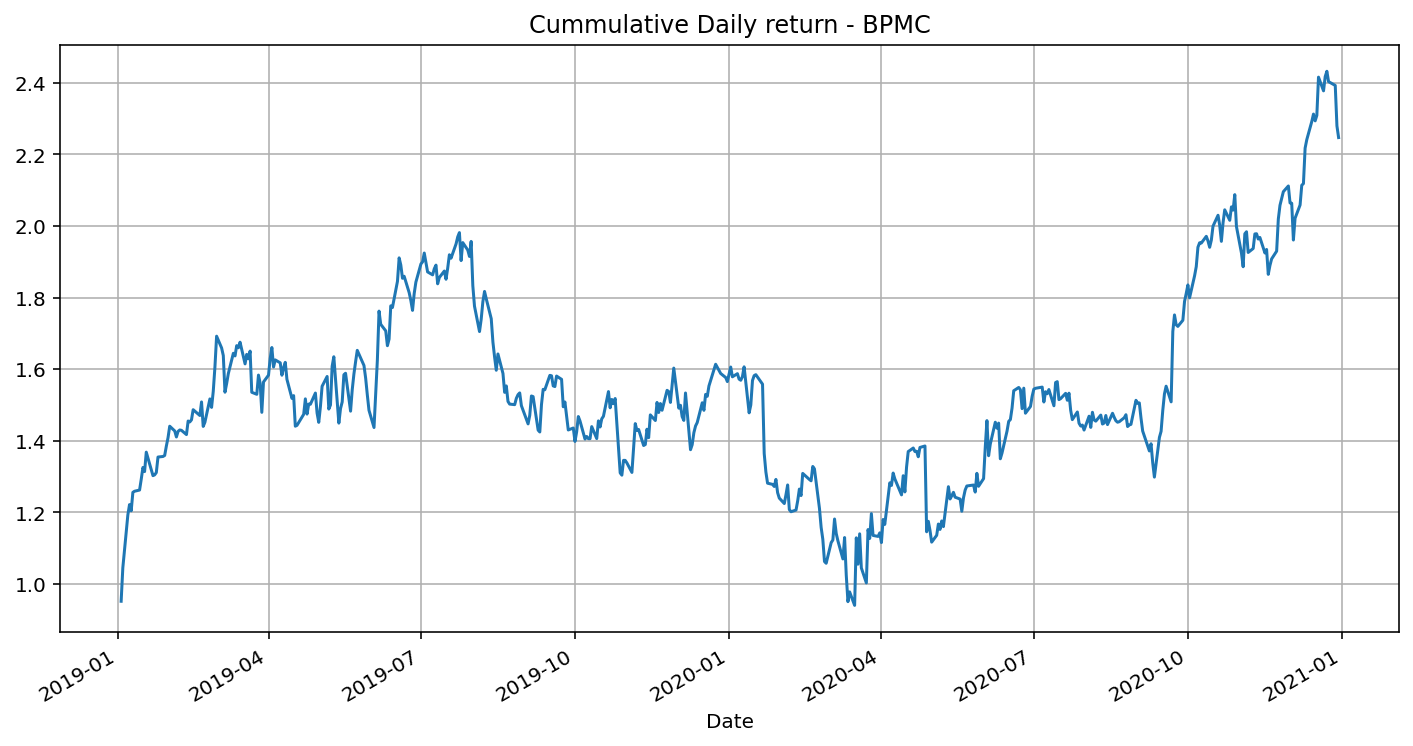

Sharp ratio: -0.09
Skewness: 0.72


In [8]:
bpmc_returns = df['BPMC'].pct_change().dropna()
bpmc_returns.plot(title = 'Daily return - BPMC', figsize=(12, 6))
plt.grid(True); plt.show()

cum_daily_return = (bpmc_returns+1).cumprod()
cum_daily_return.plot(title = 'Cummulative Daily return - BPMC', figsize=(12, 6))
plt.grid(True); plt.show()

bpmc_volatility = bpmc_returns.std() * np.sqrt(252) 
sharp_ratio = (bpmc_returns.mean() - 0.05) / bpmc_volatility
print('Sharp ratio:', round(sharp_ratio, 2))
print('Skewness:', round(df['BPMC'].skew(), 2))

## **Trend following system - NTRA:**

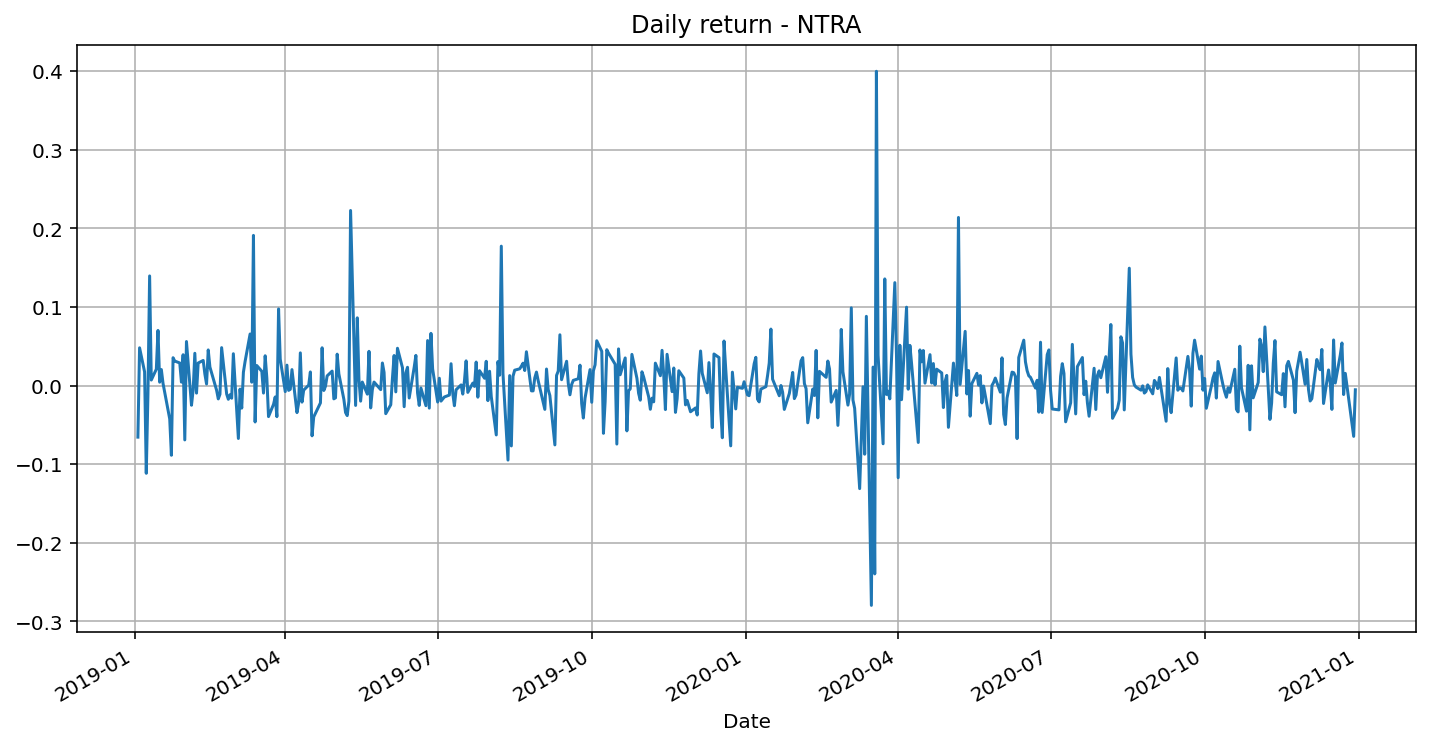

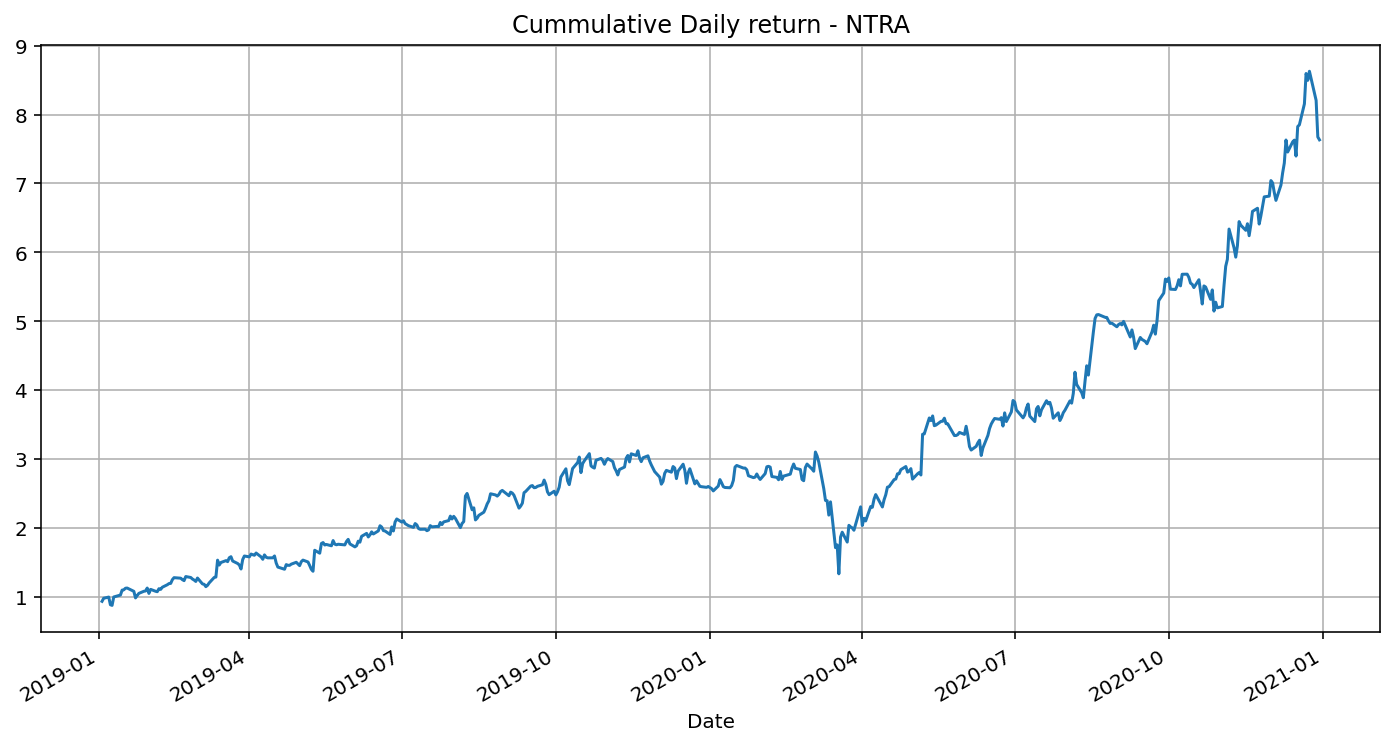

Sharp ratio: -0.06
Skewness: 1.22


In [9]:
ntra_returns = df['NTRA'].pct_change().dropna()
ntra_returns.plot(title = 'Daily return - NTRA', figsize=(12, 6))
plt.grid(True); plt.show()

cum_daily_return = (ntra_returns+1).cumprod()
cum_daily_return.plot(title = 'Cummulative Daily return - NTRA', figsize=(12, 6))
plt.grid(True); plt.show()

ntra_volatility = ntra_returns.std() * np.sqrt(252) 
sharp_ratio = (ntra_returns.mean() - 0.05) / ntra_volatility
print('Sharp ratio:', round(sharp_ratio, 2))
print('Skewness:', round(df['NTRA'].skew(), 2))

## **Trend following system - SGRY:**

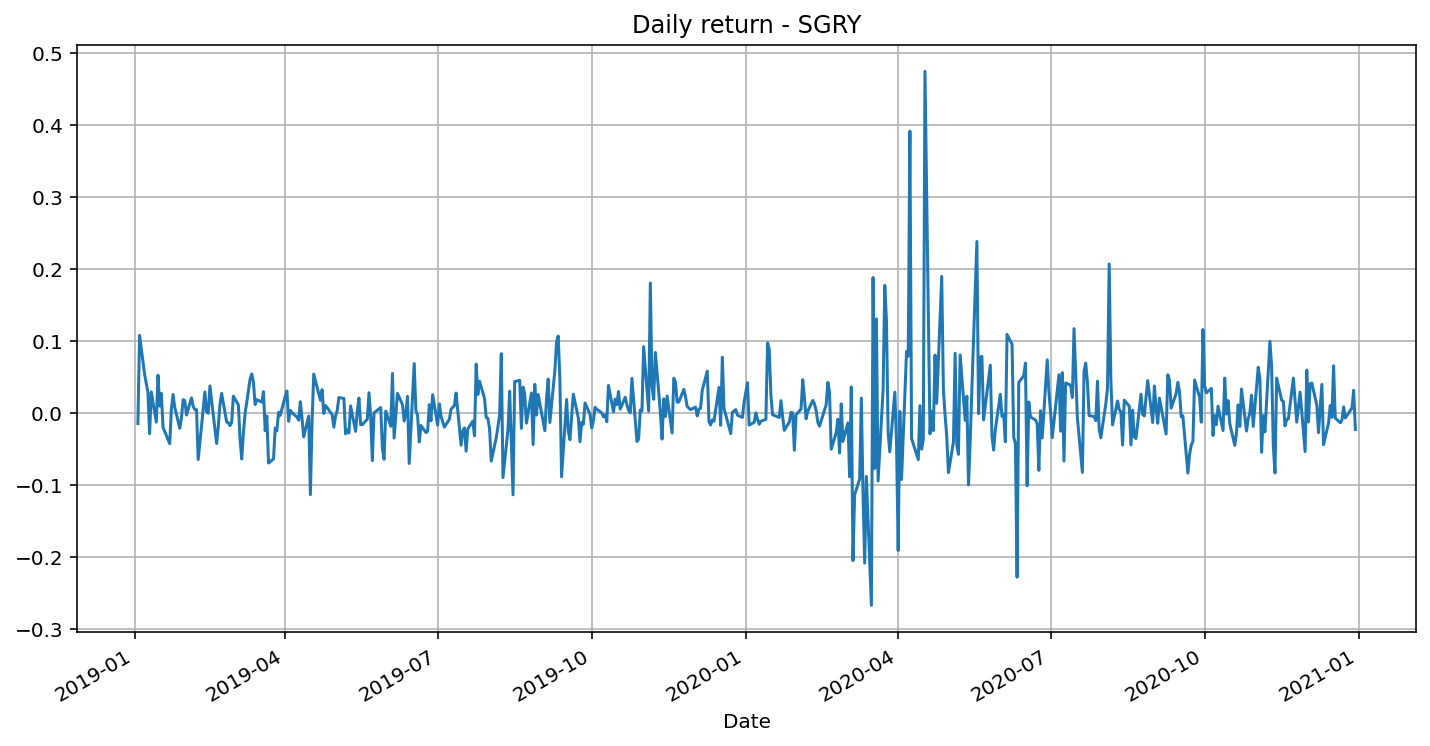

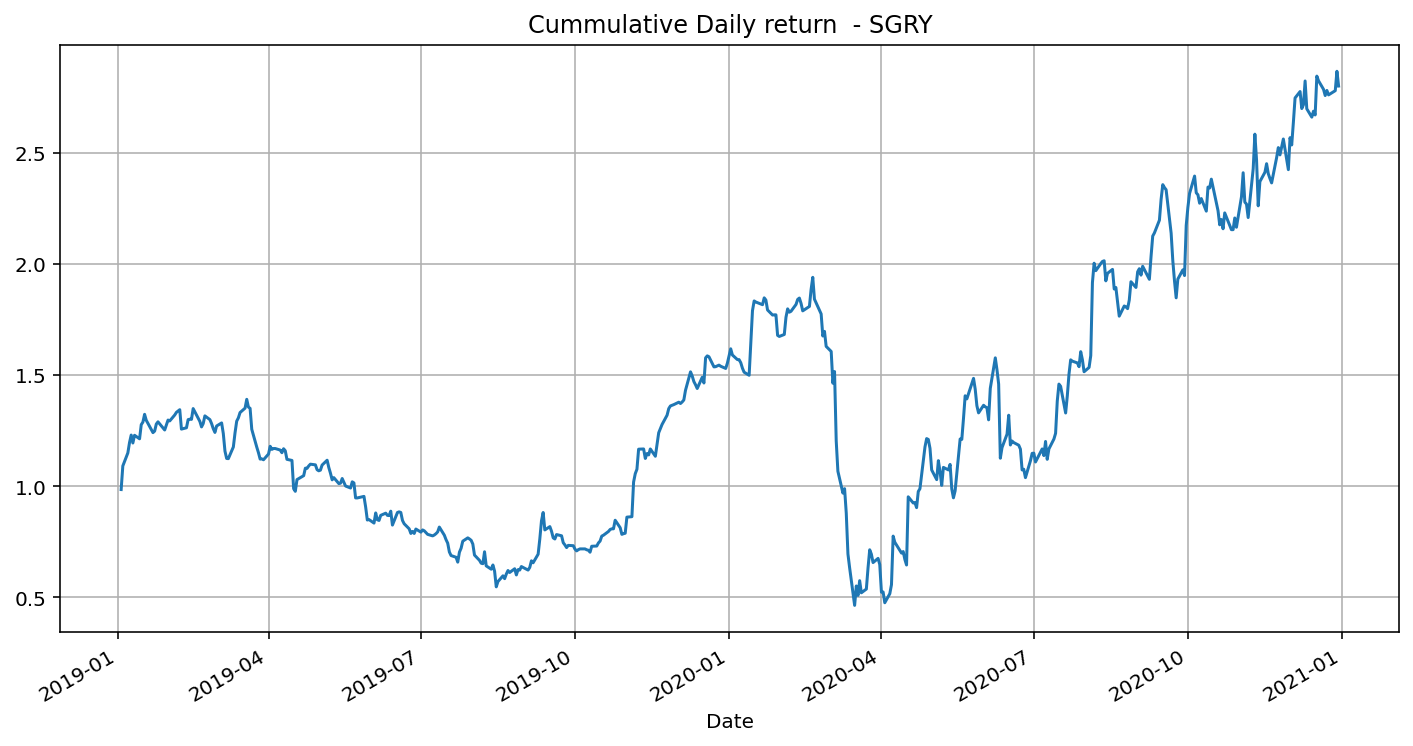

Sharp ratio: -0.05
Skewness: 0.76


In [10]:
sgry_returns = df['SGRY'].pct_change().dropna()
sgry_returns.plot(title = 'Daily return - SGRY', figsize=(12, 6))
plt.grid(True); plt.show()

cum_daily_return = (sgry_returns+1).cumprod()
cum_daily_return.plot(title = 'Cummulative Daily return  - SGRY', figsize=(12, 6))
plt.grid(True); plt.show()

sgry_volatility = sgry_returns.std() * np.sqrt(252) 
sharp_ratio = (sgry_returns.mean() - 0.05) / sgry_volatility
print('Sharp ratio:', round(sharp_ratio, 2))
print('Skewness:', round(df['SGRY'].skew(), 2))

## **Combining all 3 returns series:**

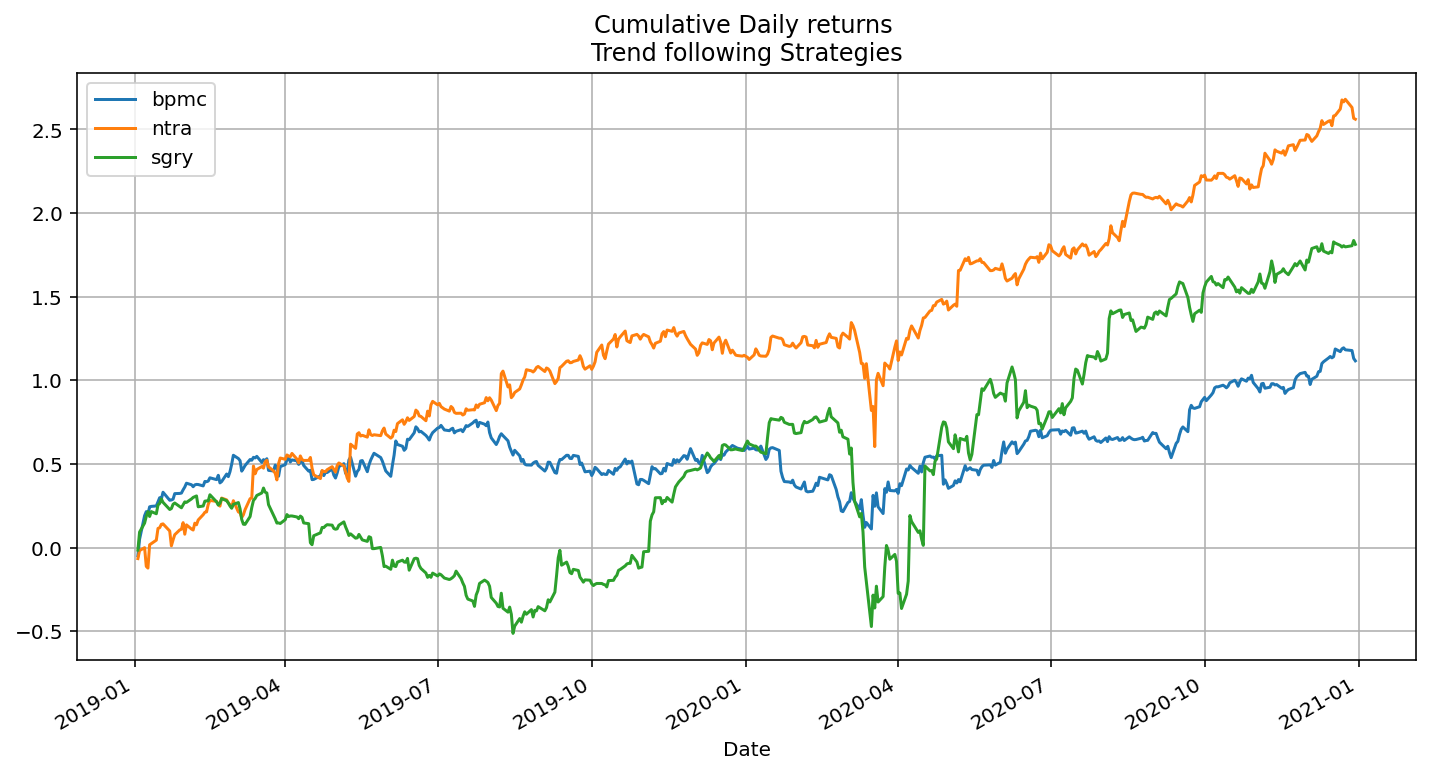

In [11]:
first_strat = pd.concat([bpmc_returns, ntra_returns, sgry_returns], 
                        axis=1, 
                        ignore_index=False)
first_strat.columns=['bpmc', 'ntra', 'sgry']
first_strat.cumsum().plot(
    title = 'Cumulative Daily returns \nTrend following Strategies', 
    figsize=(12, 6))
plt.grid(True); plt.show()

             bpmc        ntra        sgry
count  503.000000  503.000000  503.000000
mean     0.002220    0.005091    0.003604
std      0.034942    0.046172    0.056946
min     -0.173061   -0.279545   -0.267606
25%     -0.015602   -0.016887   -0.020075
50%      0.002590    0.003145    0.000000
75%      0.019709    0.025890    0.025932
max      0.200790    0.399537    0.474654


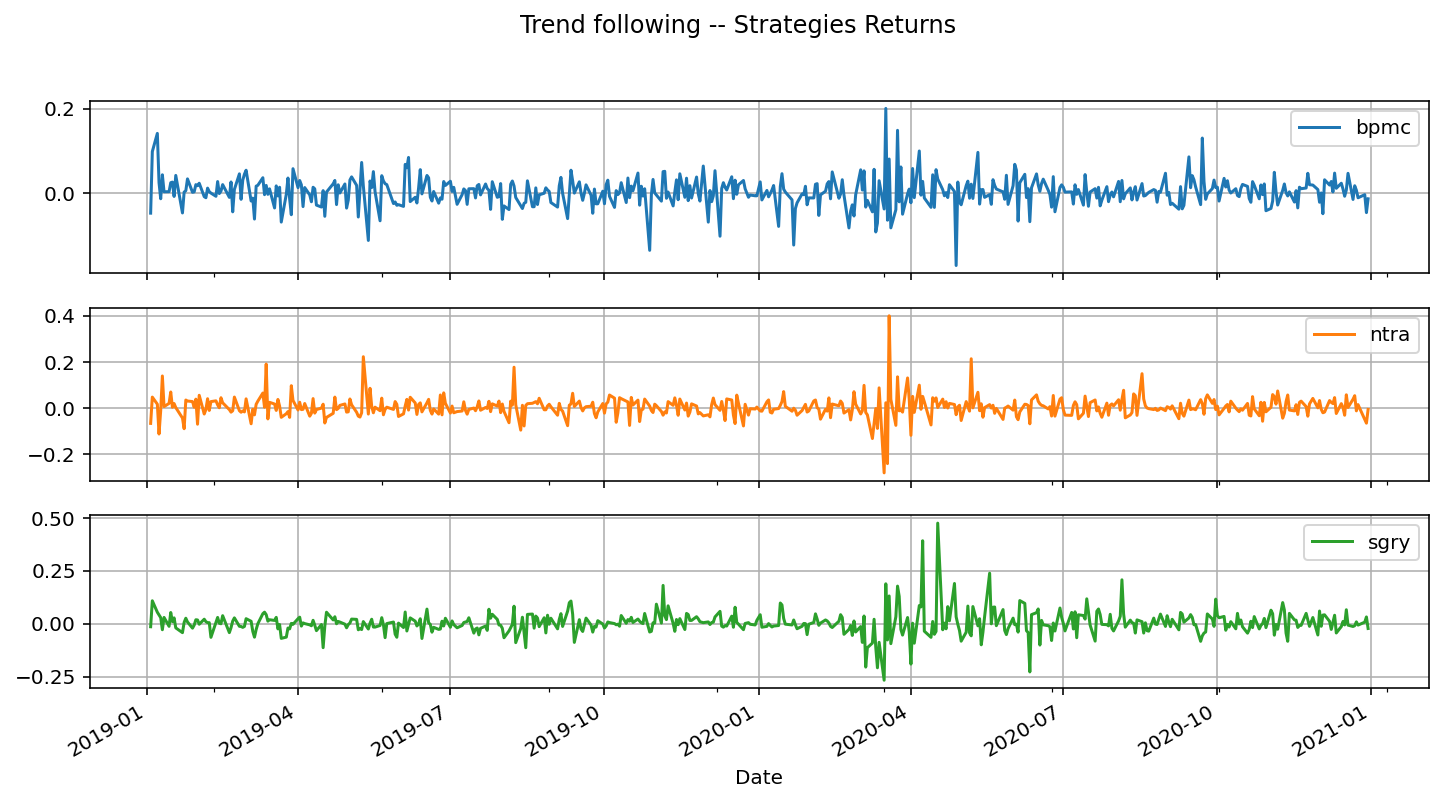

In [12]:
# decriptive statistics
print(first_strat.describe())

first_strat.plot(title="Trend following -- Strategies Returns", 
                 figsize=(12,6),
                 subplots=True, 
                 grid=True)
plt.show()

Kurtosis:
bpmc     4.967381
ntra    16.635354
sgry    16.012841
dtype: float64

Skewness:
bpmc    0.131433
ntra    1.104821
sgry    1.596739
dtype: float64


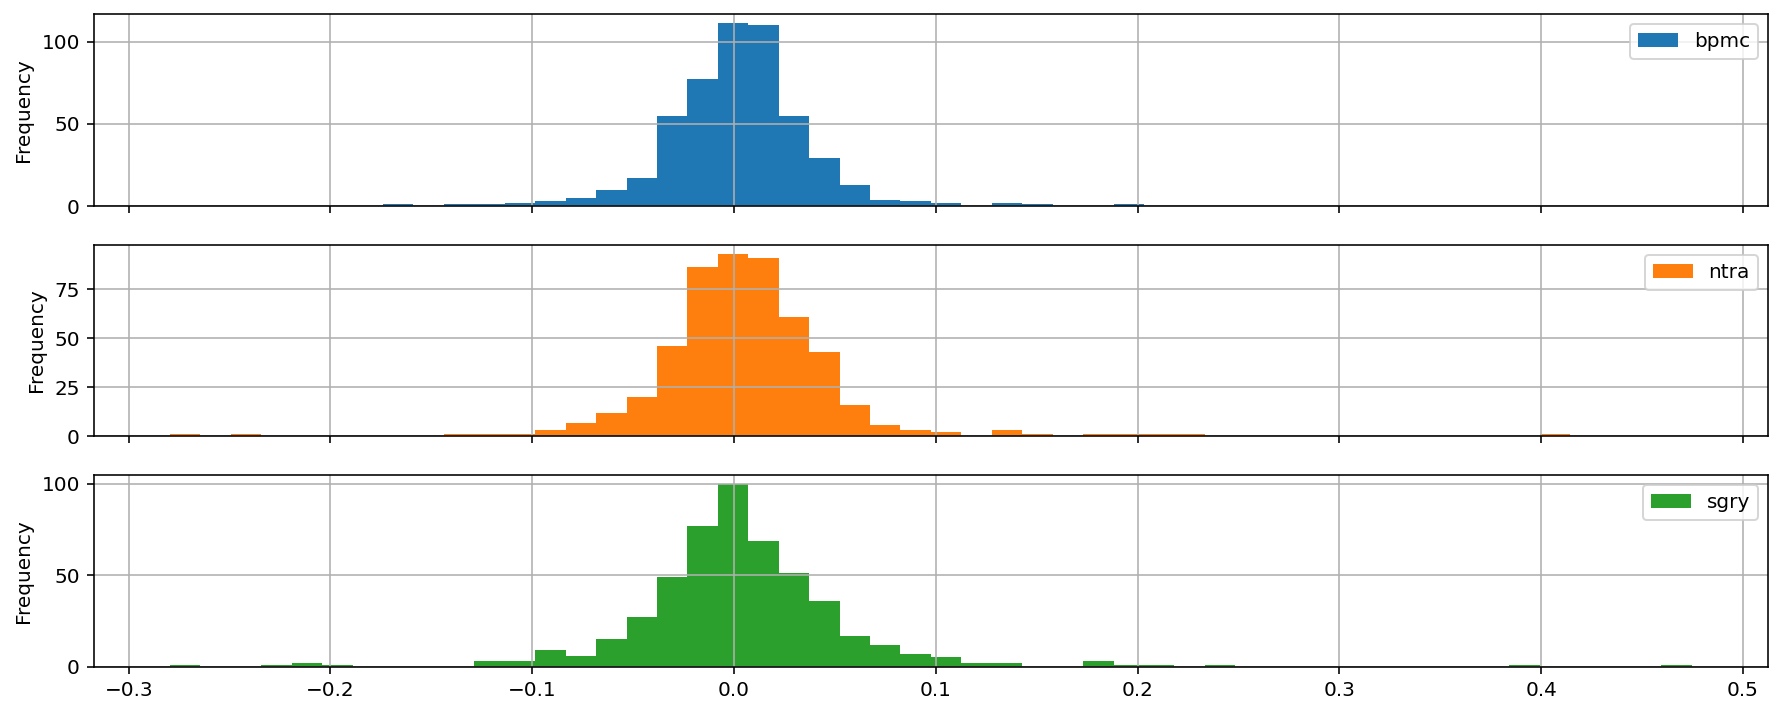

In [13]:
# Return distribution
print('Kurtosis:')
print(first_strat.kurtosis()); print()

# skewness of return
print('Skewness:')
print(first_strat.skew())

# distribution of each 
first_strat.plot(kind="hist", bins=50, subplots=True, figsize=(15,6), grid=True)
plt.show()

In [14]:
# We are going to use a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 252 days data have an expanding window
roll_max = first_strat.rolling(window, min_periods=1).max()
daily_drawdown = first_strat/roll_max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min().mean()
max_daily_drawdown


bpmc   -2.061268
ntra   -2.714491
sgry   -2.144479
dtype: float64

## **Contemporaneous correlation among the four risk measures:**

In [15]:
a = pd.DataFrame(first_strat.kurtosis()).rename(columns= {0: 'kurtosis'})
b = pd.DataFrame(first_strat.skew()).rename(columns= {0: 'skewness'})
c = pd.DataFrame(first_strat.std()).rename(columns= {0: 'StdDev'})
d = pd.DataFrame(max_daily_drawdown).rename(columns= {0: 'MDD'})
x = pd.concat([a,b,c,d], 1)
print(x); print()
x.corr()


       kurtosis  skewness    StdDev       MDD
bpmc   4.967381  0.131433  0.034942 -2.061268
ntra  16.635354  1.104821  0.046172 -2.714491
sgry  16.012841  1.596739  0.056946 -2.144479



kurtosis  skewness    StdDev       MDD
kurtosis  1.000000  0.927340  0.847748 -0.635238
skewness  0.927340  1.000000  0.984637 -0.300064
StdDev    0.847748  0.984637  1.000000 -0.128885
MDD      -0.635238 -0.300064 -0.128885  1.000000

correlation is important to know when asset or strategy returns go hand in hand in future luck. To benefit from diversification, the correlation must be 'low'.


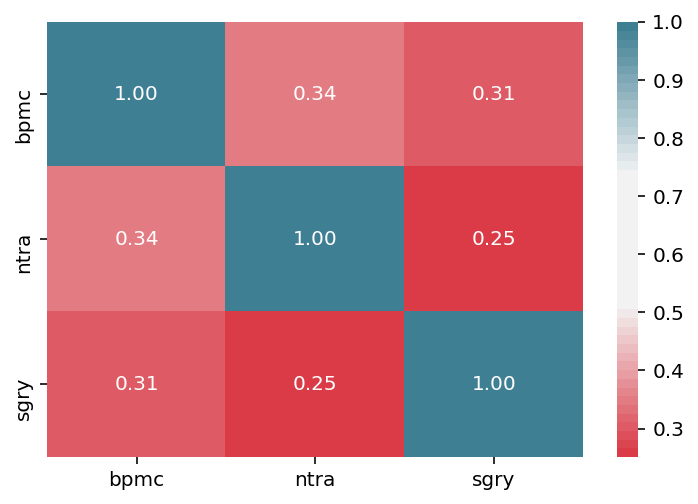

In [70]:
import seaborn as sns
corr = first_strat.corr()
# print(corr)

# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(corr, annot=True, fmt=".02f", cmap=my_cmap);

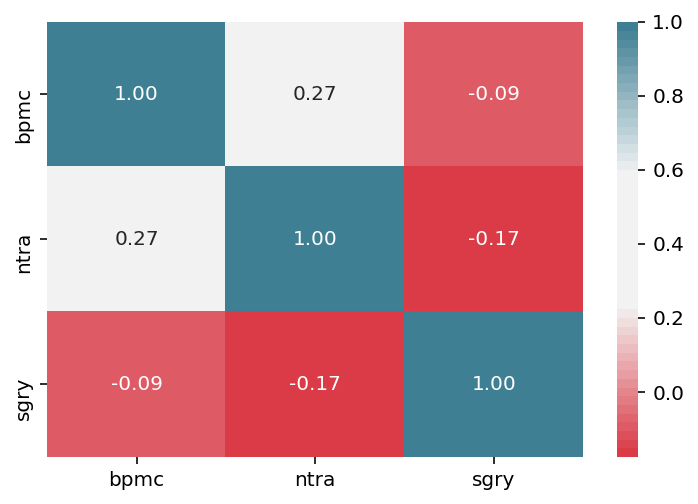

In [71]:
# analyze the correlation based on the time horizon we have as an investment
corr = first_strat[-60:].corr()
# print(corr)
sns.heatmap(corr, annot=True, fmt=".02f", cmap=my_cmap);

The above analyses give us a snapshot at a given time for a given horizon, but the reality is that the correlation varies over time and knowing this allows us to make better estimates.

we can see that the correlation is different if we consider a year:

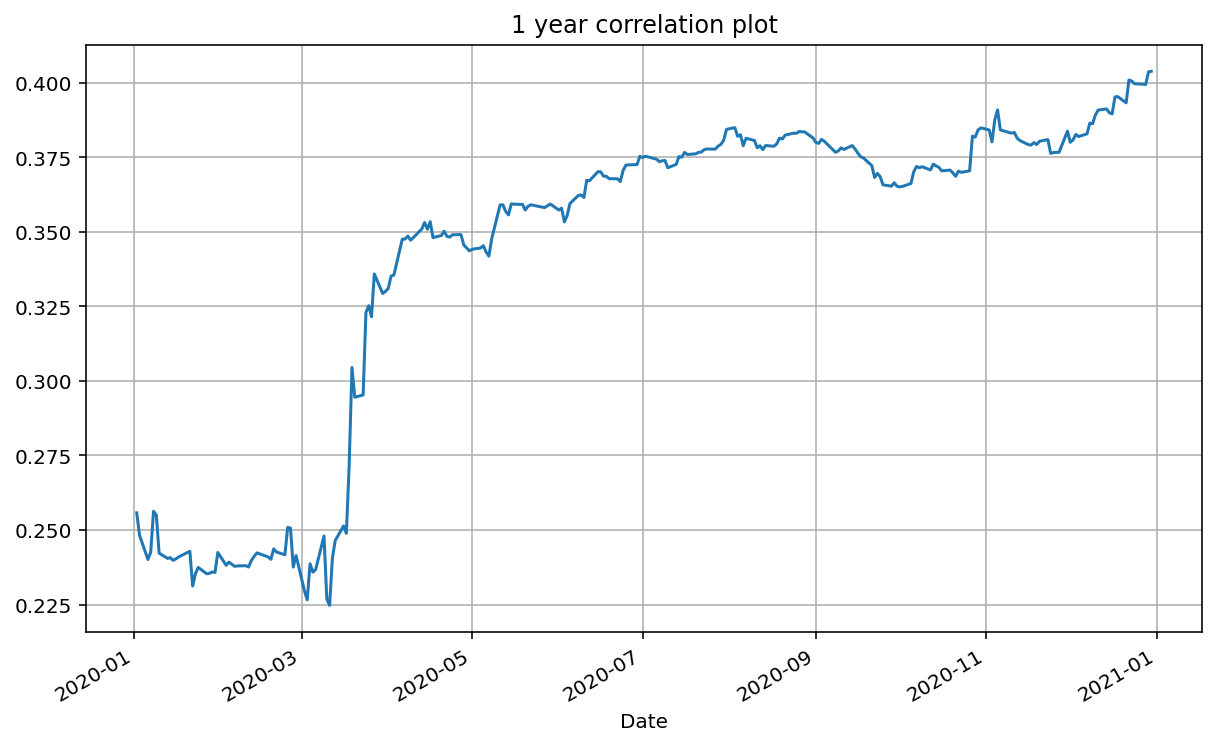

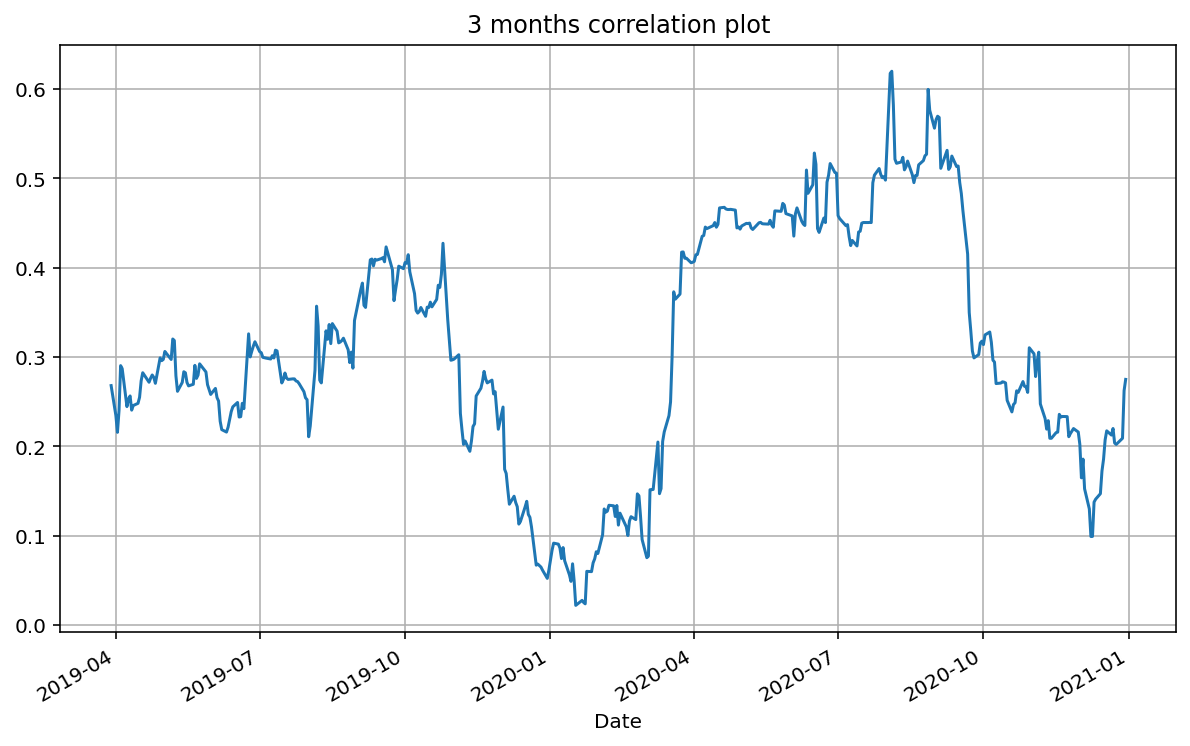

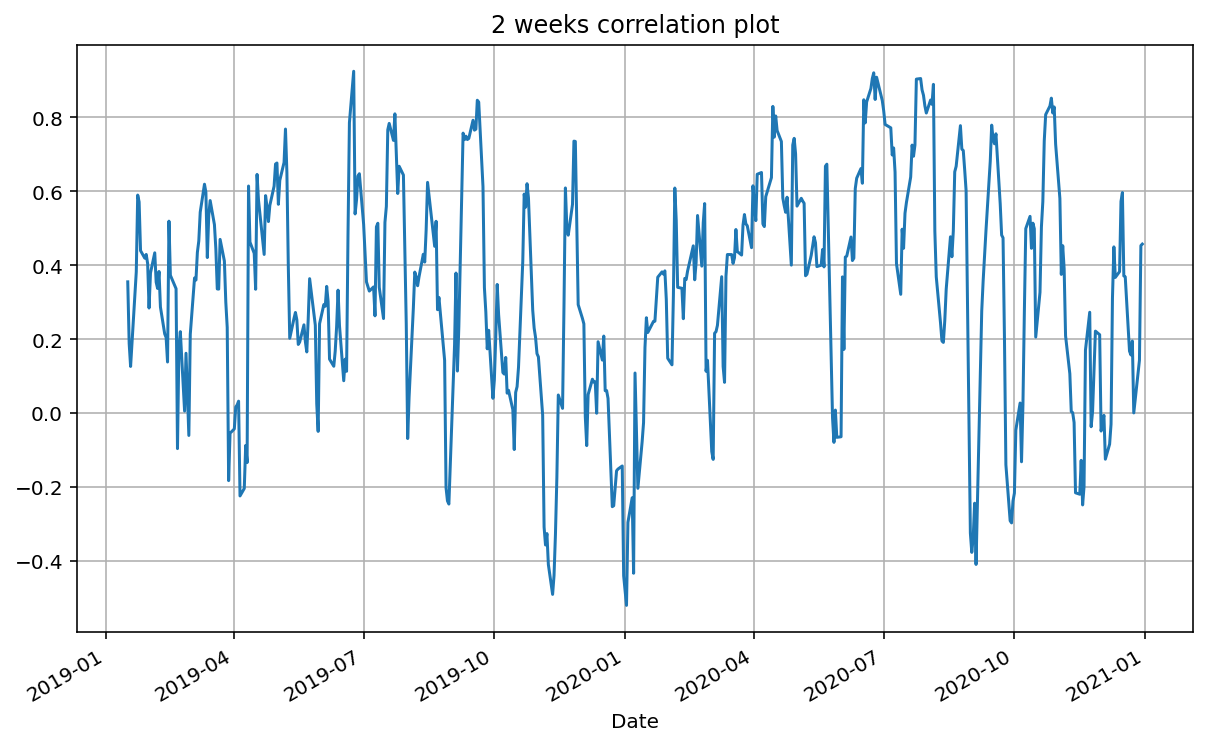

In [18]:
first_strat['bpmc'].rolling(252).corr(first_strat['ntra']).plot(grid=True, figsize = (10,6))
plt.title('1 year correlation plot')
plt.show()

# A quarter's correlation is greater than the annual correlation.
first_strat['bpmc'].rolling(60).corr(first_strat['ntra']).plot(grid=True, figsize = (10,6))
plt.title('3 months correlation plot')
plt.show()

# A quarter's correlation is greater than the annual correlation.
first_strat['bpmc'].rolling(10).corr(first_strat['ntra']).plot(grid=True, figsize = (10,6))
plt.title('2 weeks correlation plot')
plt.show()

If we reduce the horizon to two weeks, we see that the correlation is quite high. Therefore, we see that the correlation is closely related to the analysis horizon.

- Covariance indicates the direction of the linear relationship between variables.
- Correlation measures both the strength and direction of the linear relationship between two variables.


In [22]:
# Var-Cov matrix
cov_matrix = (first_strat.cov())
print('Covariance matrix:')
print(cov_matrix)

Covariance matrix:
          bpmc      ntra      sgry
bpmc  0.001221  0.000556  0.000608
ntra  0.000556  0.002132  0.000662
sgry  0.000608  0.000662  0.003243


## **Value at Risk**

# Covariance matrix:
          bpmc      ntra      sgry
bpmc  0.001221  0.000556  0.000608
ntra  0.000556  0.002132  0.000662
sgry  0.000608  0.000662  0.003243

# Expected daily return of our portfolio: 0.0033354402373814533
# Expected daily volatility of our portfoli0: 0.03181260835939475
# Average portfolio investement in absolute value: 100333.54402373816
# Average volatility of our investment in absolute value: 3181.260835939475
# Value at risk: -2.6810298899434972
# Value at Risk-15 days: -10.383584114435468
# Cut-off value: 95100.83559946444
# Historical VaR: 4899.164400535563

1 day VaR @ 95% confidence: 4899.16
2 day VaR @ 95% confidence: 6928.46
3 day VaR @ 95% confidence: 8485.6
4 day VaR @ 95% confidence: 9798.33
5 day VaR @ 95% confidence: 10954.86
6 day VaR @ 95% confidence: 12000.45
7 day VaR @ 95% confidence: 12961.97
8 day VaR @ 95% confidence: 13856.93
9 day VaR @ 95% confidence: 14697.49
10 day VaR @ 95% confidence: 15492.52
11 day VaR @ 95% confidence: 16248.69
12 d

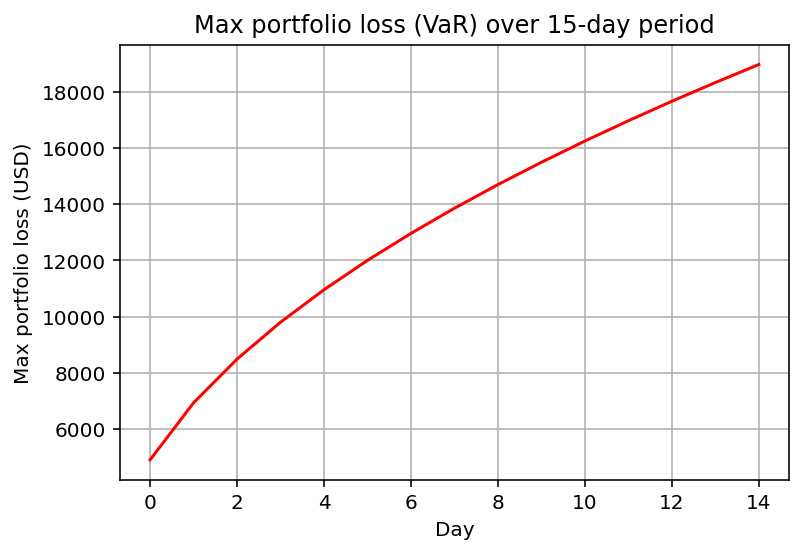

In [23]:
initial_investment = float(100000)
# set random weights for portfolio
weights = np.random.random(len(first_strat.columns))
# normalizing weights
weights /= np.sum(weights)
# mean returns for each stock
avg_rets = first_strat.mean()
# Var-Cov matrix
cov_matrix = first_strat.cov()
print('# Covariance matrix:')
print(cov_matrix); print()
 
# mean returns for portfolio overall, 
portfolio_mean = avg_rets @ weights
print('# Expected daily return of our portfolio:', portfolio_mean); 
 
# portfolio standard deviation
portfolio_std = np.sqrt(weights.T @ cov_matrix @ weights)
print('# Expected daily volatility of our portfoli0:', portfolio_std); 
 
# mean of investment
mean_investment = (1+portfolio_mean) * initial_investment
print('# Average portfolio investement in absolute value:', mean_investment); 
             
# standard deviation of investmnet
std_investment = initial_investment * portfolio_std
print('# Average volatility of our investment in absolute value:', std_investment);

from scipy.stats import norm
CI = 0.05
VaR = norm.ppf(portfolio_mean, portfolio_std)
print('# Value at risk:', VaR)

num_days = float(15)
print('# Value at Risk-15 days:', VaR * np.sqrt(num_days))

cut_off = norm.ppf(CI, mean_investment, std_investment)
print('# Cut-off value:', cut_off)

histVaR = initial_investment - cut_off
print('# Historical VaR:', histVaR); print()

var_array = []
num_days = int(15)
for x in range(1, num_days+1):    
    var_array.append(np.round(histVaR * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(histVaR * np.sqrt(x),2)))
# Build plot
plt.xlabel("Day")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")
plt.grid(True)
plt.show()

In [ ]:
!pip install git+https://github.com/quantopian/pyfolio
import pyfolio as pf
# performance analysis
# pf.tears.create_returns_tear_sheet(pd.Series(first_strat['bpmc']))

We can see here that, with the passage of time, this risk probability is increasing.

## **Equal weighted portfolio**
The problem we are dealing with is knowing how to distribute the available capital between each of the portfolio strategies that have passed the mandatory robust backtesting. To know if we are doing well, we need something to compare ourselves with, the benchmark, and it must have characteristics similar to what we want to compare.

For example, the trend following system should be compared with a strategy of buying and holding a portfolio with the same assets.

Here we are going to create a portfolio whose weights are identical for each of the instruments, not differentiate the type of strategy. It serves as a basis for comparing the balance of weights that we will be testing.

In [25]:
# no_of_stocks = first_strat.shape[1]
# # weights
# port_weights = no_of_stocks * [1 / no_of_stocks]
# # portfolio return
# port_rets = pd.Series(np.dot(port_weights, first_strat.T),                     
#                       index = first_strat.index)
# # simple tear sheet
# pf.create_simple_tear_sheet(port_rets)

In [26]:
no_of_stocks = first_strat.shape[1]
print(no_of_stocks)
# Compute the variable to get the weights
port_weights = cp.Variable(no_of_stocks)
print(port_weights.shape)

3
(3,)


In [40]:
# portfolio returns = daily return * weight for each asset.
port_rets = (np.array(first_strat) * port_weights)
print(port_rets)

[[-0.04845642 -0.06563702 -0.01488091]
 [ 0.09815192  0.04793388  0.10775425]
 [ 0.14136128  0.0173501   0.05363638]
 ...
 [-0.00447157 -0.04904238  0.00682964]
 [-0.04720293 -0.06465276  0.03141732]
 [-0.01431386 -0.00543315 -0.02319142]] * var70


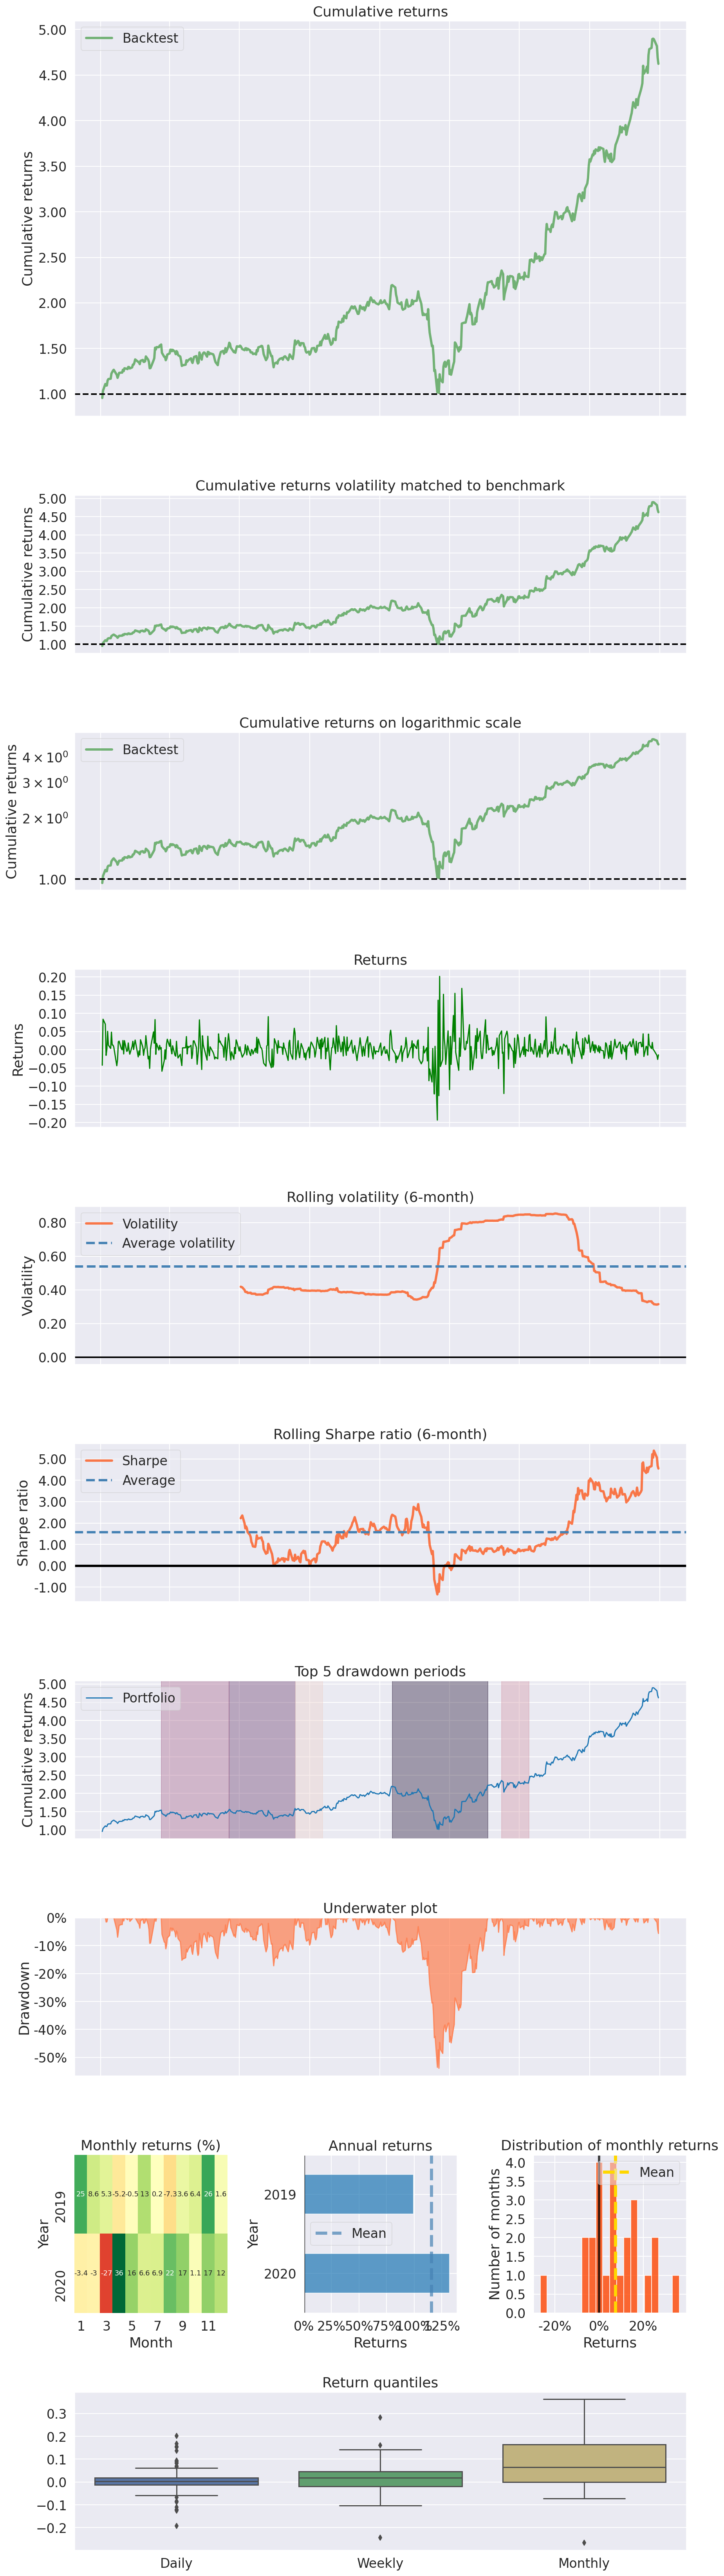

In [28]:
port_tot_ret = np.sum([0.33, 0.33, 0.33] * first_strat, axis=1)
pf.tears.create_returns_tear_sheet(pd.Series(port_tot_ret))

## Portfolio weights optimized with Kelly criterion
Kelly's criterion is one of the methods available to estimate the weights of our portfolio and maximize the benefit with minimum risk for the analyzed portfolio.


In [29]:
# no_of_stocks = first_strat.shape[1]
# print(no_of_stocks)
# # Compute the variable to get the weights
# weights = cp.Variable(no_of_stocks)
# weights.shape

# # The portfolio returns are based on the daily return multiplied by the weight for each asset.
# portfolio_returns = (np.array(first_strat)*weights)
# print(portfolio_returns)

In [30]:
# # The portfolio returns are based on the daily return multiplied by the weight for each asset.
# portfolio_returns = (np.array(first_strat)*weights)
# print(portfolio_returns)

## **Max-return, Min-volatility portfolio:**

In [50]:
Sigma = np.cov(first_strat.transpose())
# number of assets
n = Sigma.shape[0]
# average returns
mu = first_strat.mean().values
# asset SDs
asset_vols = np.sqrt(Sigma)
# variable to optimize over - portfolio weights
w = cp.Variable(n)
# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

prob = cp.Problem(cp.Minimize(vol),  # minimize volatility
                  [cp.sum(w) == 1,   # sum of weights = 1
                   w >= 0]           # weights > 0 (long-only)
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
minvol = vol.value

labels = list(first_strat.columns)
print(labels); print()
z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

['bpmc', 'ntra', 'sgry']



bpmc  ...                                               sgry
rows                                                            ...                                                   
real return                                         0.00221958  ...                                         0.00360363
vol          [0.03494235307113064, 0.02358891952775331, 0.0...  ...  [0.024659843811079444, 0.02572366004326203, 0....

[2 rows x 3 columns]

Now we have the leftmost point on the efficient frontier. We will use cvxpy to find the rightmost point which is 100% in the highest-performing asset.

## **Max Return**

In [54]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret),  # maximize return
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value

print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)

Max return portfolio weights


bpmc  ntra  sgry
0   0.0   1.0   0.0

## **Min Volatility**

In [72]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
# round to not get x.xxxxE-22
wts = [float('%0.6f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)

Min vol portfolio weights


bpmc      ntra      sgry
0  0.613309  0.254189  0.132502

Finally, we trace out the rest of the frontier. We create an array of 200 volatilities between minvol and maxretvol inclusive. For each volatility, we solve the optimization for the highest return portfolio subject to volatility <= vol:

In [56]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit   # new constraint: vol <= vol_limit parameter
                  ]
                 )

# define helper function 
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate over vl_vals
results_dict = {}
for vl_val in vl_vals:
    results_dict[vl_val] = solve_vl(vl_val)

ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
print(ret_df)

       i       vol    return       std          bpmc      ntra      sgry
0      0  0.000971  0.003133  0.031158  6.130870e-01  0.254386  0.132527
1      1  0.000977  0.003281  0.031252  5.586418e-01  0.302794  0.138564
2      2  0.000983  0.003342  0.031345  5.360119e-01  0.322940  0.141048
3      3  0.000988  0.003389  0.031438  5.186228e-01  0.338376  0.143002
4      4  0.000994  0.003429  0.031531  5.039946e-01  0.351418  0.144588
..   ...       ...       ...       ...           ...       ...       ...
195  195  0.002109  0.005079  0.045919  1.405142e-07  0.991974  0.008026
196  196  0.002114  0.005082  0.045982  9.256902e-08  0.993998  0.006002
197  197  0.002120  0.005085  0.046046  9.384560e-08  0.996009  0.003991
198  198  0.002126  0.005088  0.046109  2.602510e-07  0.998009  0.001990
199  199  0.002132  0.005091  0.046172  8.252292e-08  0.999998  0.000002

[200 rows x 7 columns]
CPU times: user 1.87 s, sys: 47.2 ms, total: 1.92 s
Wall time: 1.87 s


## **Plot efficient frontier**

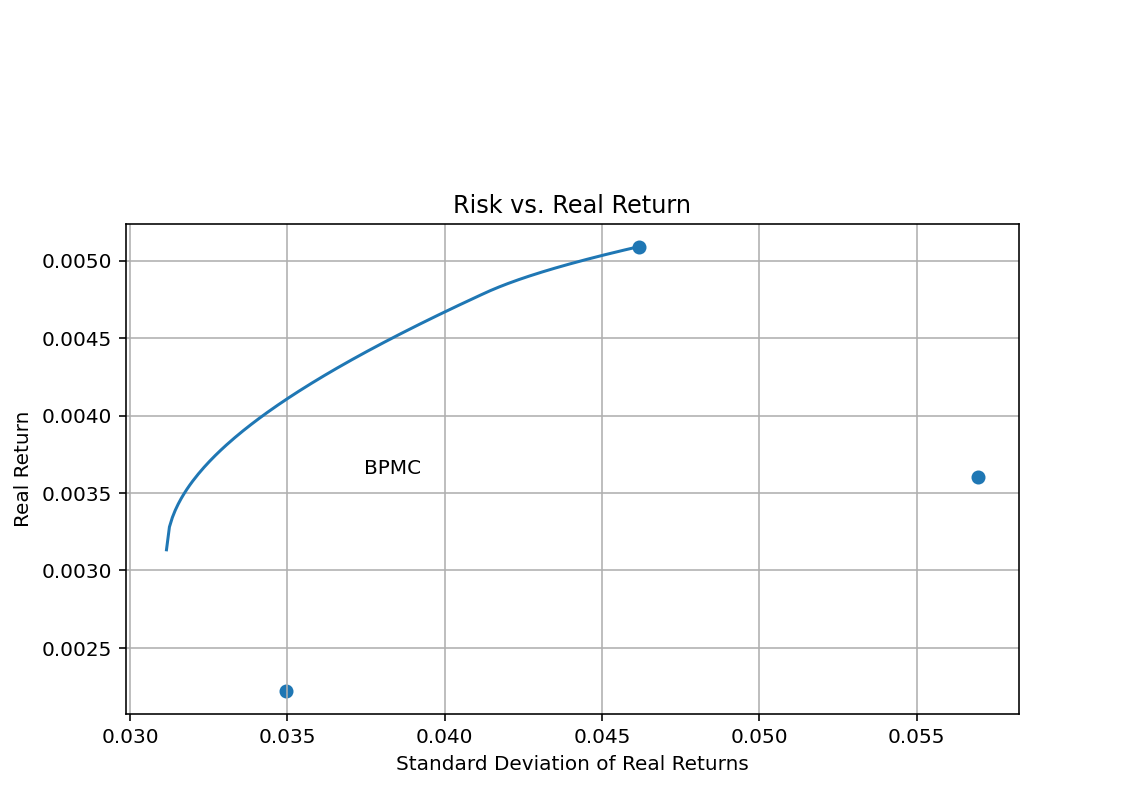

In [64]:
def plot_efrontier(ret_df, first_strat,
                   xlabel="Standard Deviation of Real Returns",
                   ylabel="Real Return",
                   title=None):

    Sigma = np.cov(first_strat.transpose())
    n = Sigma.shape[0]
    mu = first_strat.mean().values
    asset_vols = np.sqrt(Sigma.diagonal())

    plt.figure(figsize=(8, 4.5))
    plt.grid(True)

    # plot the data
    plt.plot(ret_df['std'], ret_df['return'])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("Risk vs. Real Return")

    # plot the markers
    plt.scatter(asset_vols, mu)
    xoffset = 0.0025
    yoffset = 0.0015
    labels = df.columns
    for i, label in enumerate(labels):
        plt.annotate(label, xy=(asset_vols[i]+xoffset, mu[i]+yoffset),  xycoords='data',
                     horizontalalignment='left', verticalalignment='top',
                    )
        
plot_efrontier(ret_df, first_strat)

## **Transition map**

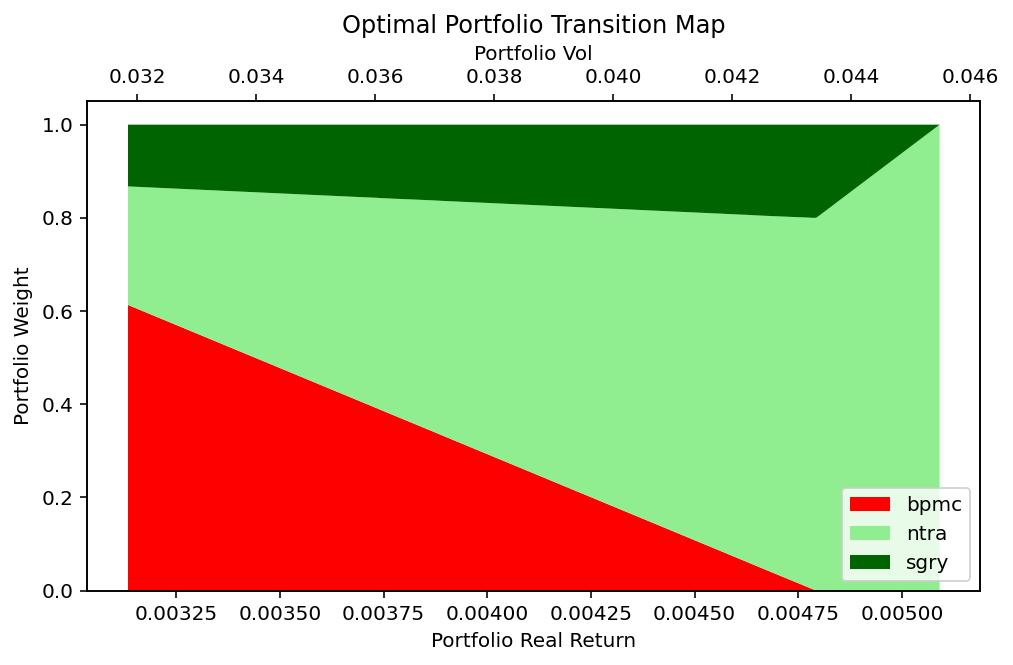

In [67]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
def transition_map(ret_df, labels, startyear, endyear):
    
    x = ret_df['return']
    # absolute values so shorts don't create chaos
    y_list = [abs(ret_df[l]) for l in labels]
    pal = ['red', 'lightgreen', 'darkgreen', 'navy', 'gold', 'cyan']
    
    fig = plt.figure(figsize=(8, 4.5))
    ax1 = fig.add_subplot(111)

    ax1.stackplot(x, y_list, labels=labels, colors=pal)
    ax1.set_xlabel("Portfolio Real Return")
    ax1.set_ylabel("Portfolio Weight")
    ax1.legend(loc='lower right')
    ax2 = ax1.twiny()
    ax2.set_xlim((ret_df['std'].iloc[0], ret_df['std'].iloc[-1]))
    ax2.set_xlabel('Portfolio Vol')
    
    
    plt.title("Optimal Portfolio Transition Map");

transition_map(ret_df, labels=first_strat.columns, startyear=first_strat.index[0], endyear=first_strat.index[-1])

In [55]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
# round to not get x.xxxxE-22
wts = [float('%0.6f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)

Min vol portfolio weights


bpmc      ntra      sgry
0  0.613309  0.254189  0.132502

## **Kelly Criterion**
The final portfolio value or the utility of the portfolio can be computed using the logarithmic summation of the daily portfolio returns.

In [31]:
final_port_val = cp.sum(cp.log(1 + port_rets))
print(final_port_val)

Sum(log(1.0 + [[-0.04845642 -0.06563702 -0.01488091]
 [ 0.09815192  0.04793388  0.10775425]
 [ 0.14136128  0.0173501   0.05363638]
 ...
 [-0.00447157 -0.04904238  0.00682964]
 [-0.04720293 -0.06465276  0.03141732]
 [-0.01431386 -0.00543315 -0.02319142]] * var0), None, False)


The output tells us that the final_portfolio_value is an expression and is concave in nature and its value is unknown

The objective of this example is to maximise the Kelly criterion. To do this, you can create a parameter called 'objective' and assign the maximisation condition to it. The Maximize function of the cvxpy library is used for this purpose.

In [32]:
objective = cp.Maximize(final_port_val)
print(objective)

maximize Sum(log(1.0 + [[-0.04845642 -0.06563702 -0.01488091]
 [ 0.09815192  0.04793388  0.10775425]
 [ 0.14136128  0.0173501   0.05363638]
 ...
 [-0.00447157 -0.04904238  0.00682964]
 [-0.04720293 -0.06465276  0.03141732]
 [-0.01431386 -0.00543315 -0.02319142]] * var0), None, False)


The output tells us that the objective is a Maximize function over the expression. The expression is concave in nature and its value is unknown

We need to remember that there are certain constraints on the weights of the portfolio.

- The weights should positive, as we are considering to use a strategy or not.
- The sum of weights should be less than or equal to 1, as we are not considering leveraging.

In [33]:
constraints = [0.0 <= port_weights, cp.sum(port_weights) == 1]
print(constraints)

[Inequality(Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ()))]


Here the constraints specify that the first one is an inequality constraint and its value is a constant zero. While the second is an equality constraint between an affine expression whose value is equal to a constant non-negative value

Now, we can combine both the objective and the constraints to create a problem statement. We can do this by using the Problem class of the cvxpy library, as shown below.

In [34]:
problem = cp.Problem(objective, constraints)
print(problem)

maximize Sum(log(1.0 + [[-0.04845642 -0.06563702 -0.01488091]
 [ 0.09815192  0.04793388  0.10775425]
 [ 0.14136128  0.0173501   0.05363638]
 ...
 [-0.00447157 -0.04904238  0.00682964]
 [-0.04720293 -0.06465276  0.03141732]
 [-0.01431386 -0.00543315 -0.02319142]] * var0), None, False)
subject to 0.0 <= var0
           Sum(var0, None, False) == 1.0


Here the output describes the entire problem including all the previously described expression into a one single statement

We can use the solve method of the problem class to get the best weight combination as shown below:

In [35]:
# The optimal objective value is returned by `prob.solve()`.
problem.solve()

# The optimal value for w is stored in `w.value`.
print(port_weights.value)
print(np.rint(port_weights.value))

[6.39960835e-12 1.00000000e+00 1.70068924e-10]
[0. 1. 0.]


These are the optimal weights according to Kelly's criterion, as we can see the first and third strategies have such a small weight that we discard them and simplified, we can say that the remaining one have a similar weight.

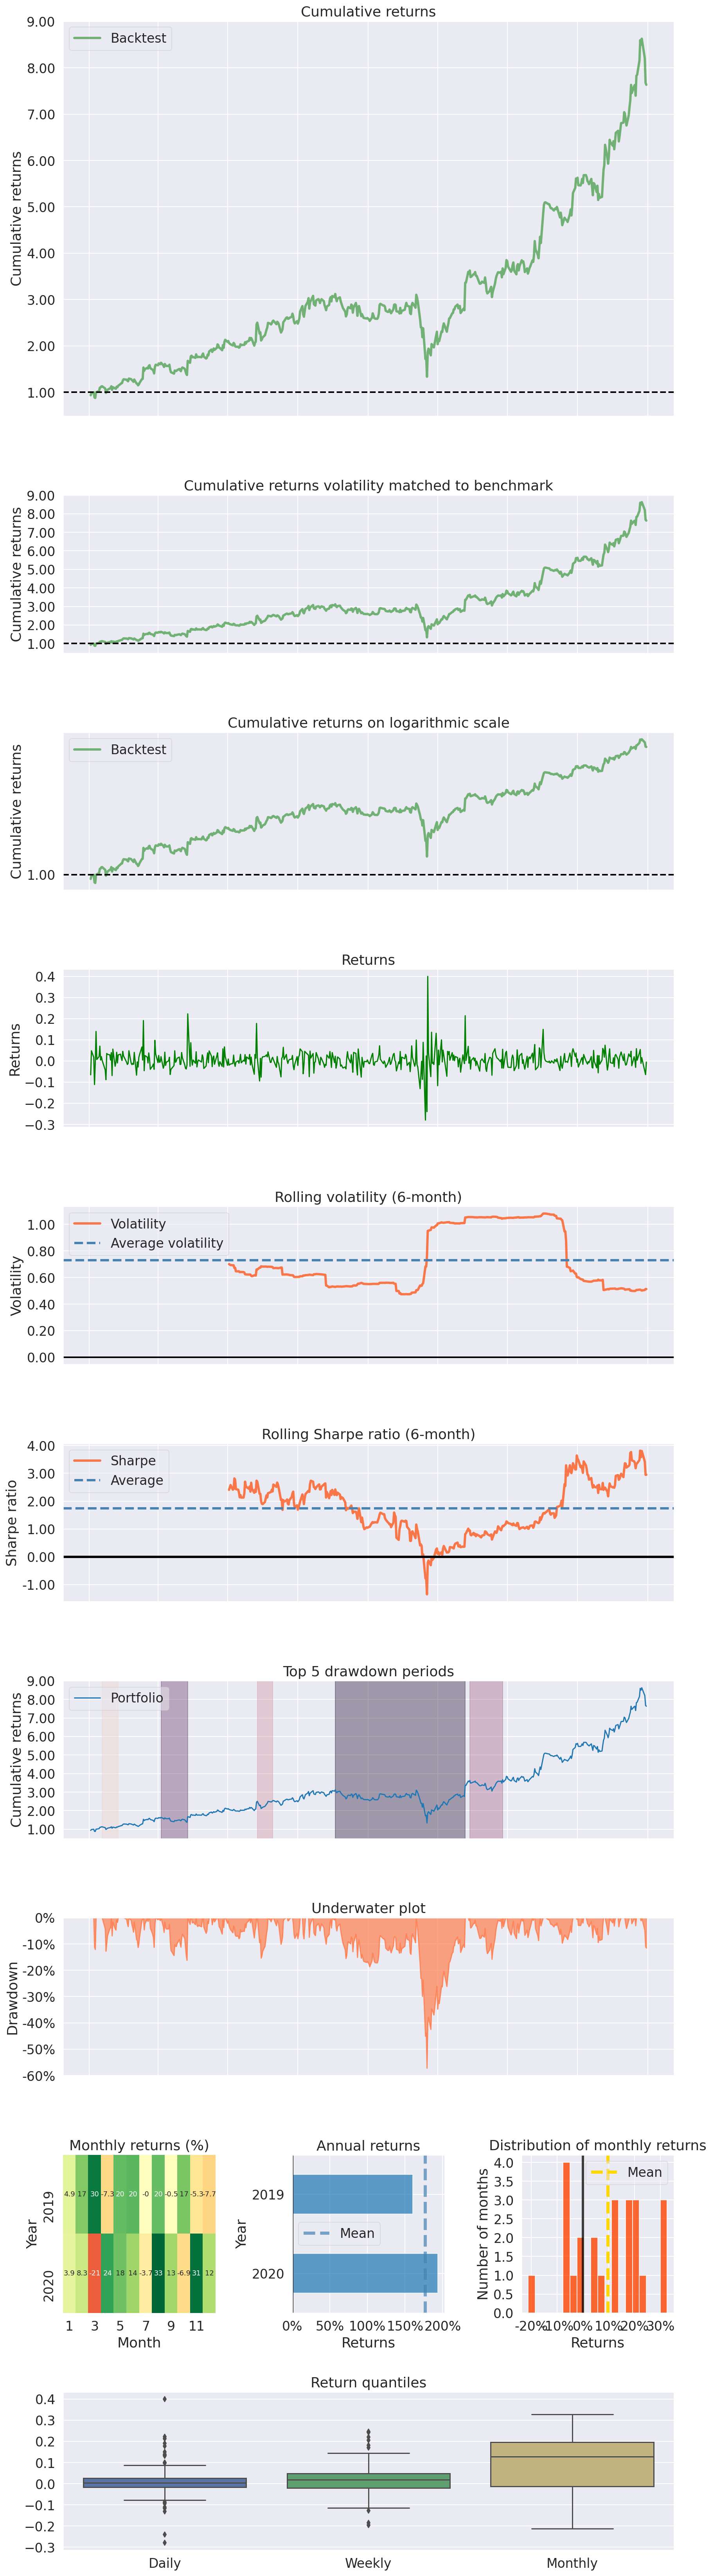

In [36]:
port_tot_ret_kelly = np.sum(port_weights.value * first_strat, axis=1)
pf.tears.create_returns_tear_sheet(port_tot_ret_kelly)

If we compare it with the initial portfolio with the equally distributed weights, we see that Kelly's optimization has improved the annualized return, the cumulative one, the SR and increased the volatility.

## **Efficient Frontier using convex optimization**



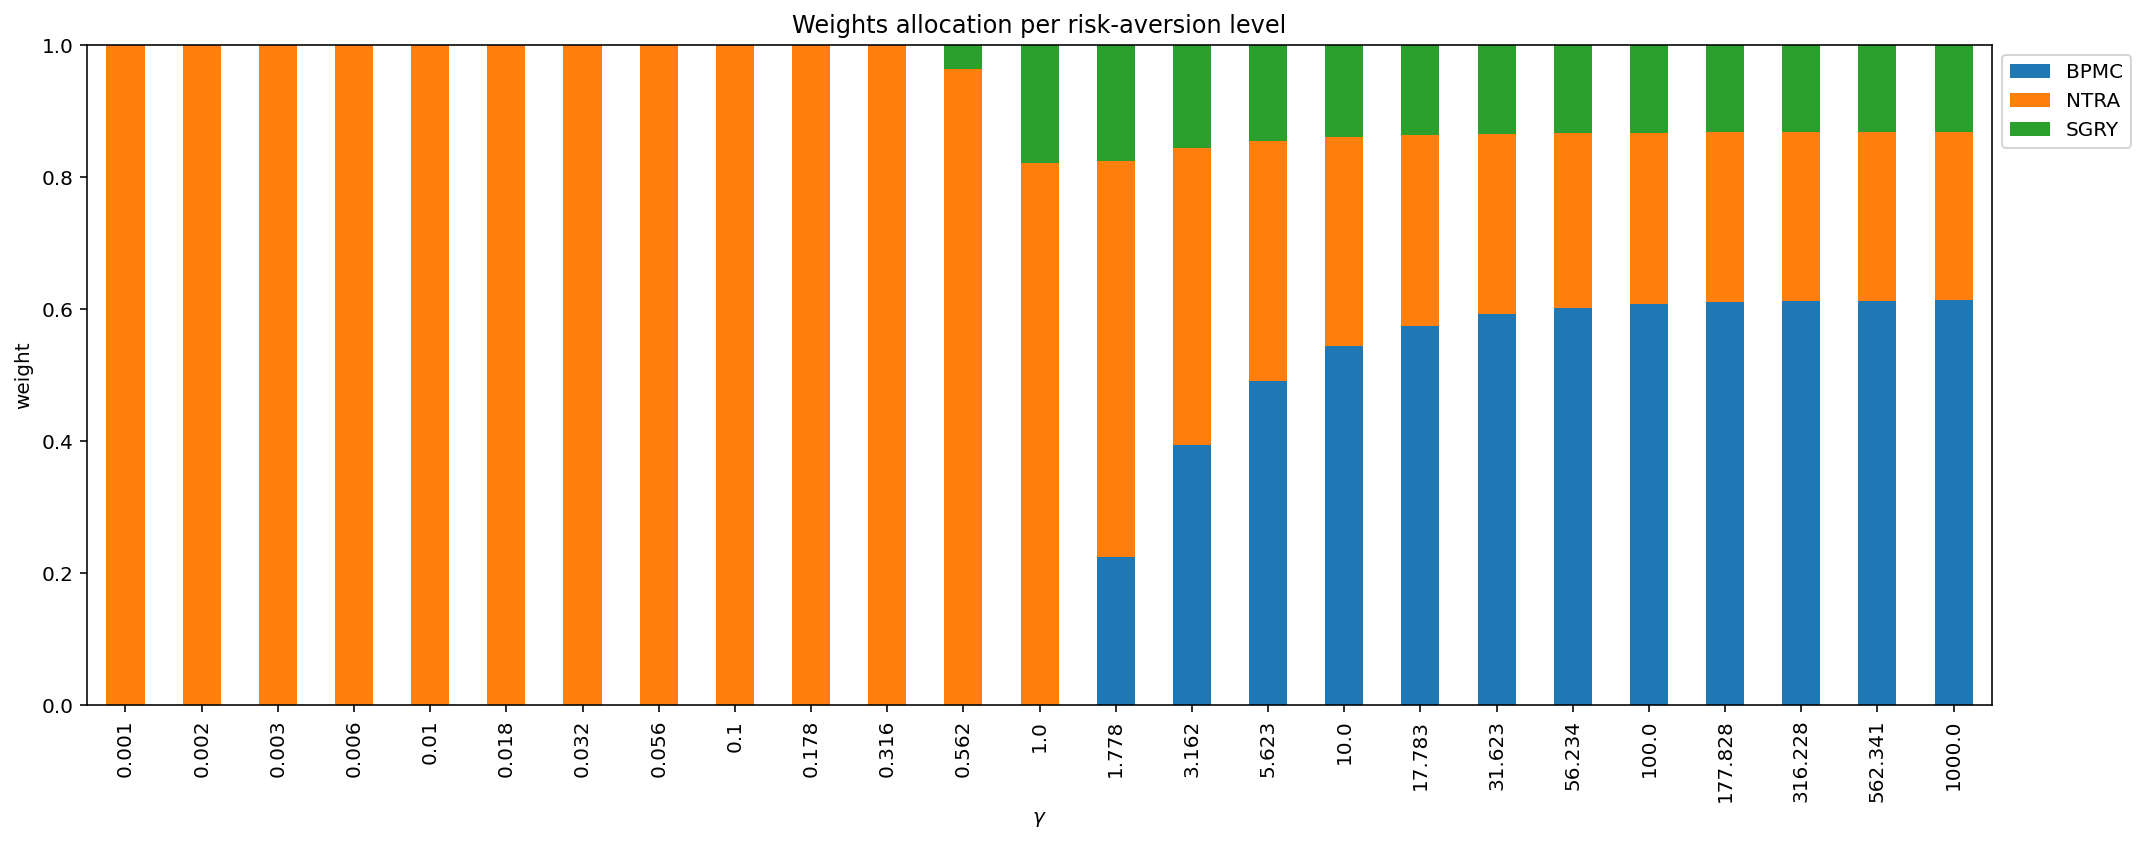

In [37]:
import cvxpy as cp

num_port = 3
num_days = 252
avg_returns = first_strat.mean() * num_days
cov_mat = first_strat.cov() * num_days

# Convert the annualized average returns and the covariance matrix to numpy arrays:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

# Set up the optimization problem:
port_weights = cp.Variable(no_of_stocks)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns * port_weights 
portf_vol_cvx = cp.quad_form(port_weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function, 
                     [cp.sum(port_weights) == 1, port_weights >= 0])

# Calculate the Efficient Frontier:

num_points = 25
portf_rtn_cvx_ef = np.zeros(num_points)
portf_vol_cvx_ef = np.zeros(num_points)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=num_points)

for i in range(num_points):
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(port_weights.value)

# Plot the allocation for different values of the risk-aversion parameter:
weights_df = pd.DataFrame(weights_ef, 
                          columns=df.columns, 
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True, figsize = (15,6)) 
ax.set(title='Weights allocation per risk-aversion level',
       xlabel=r'$\gamma$', 
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()


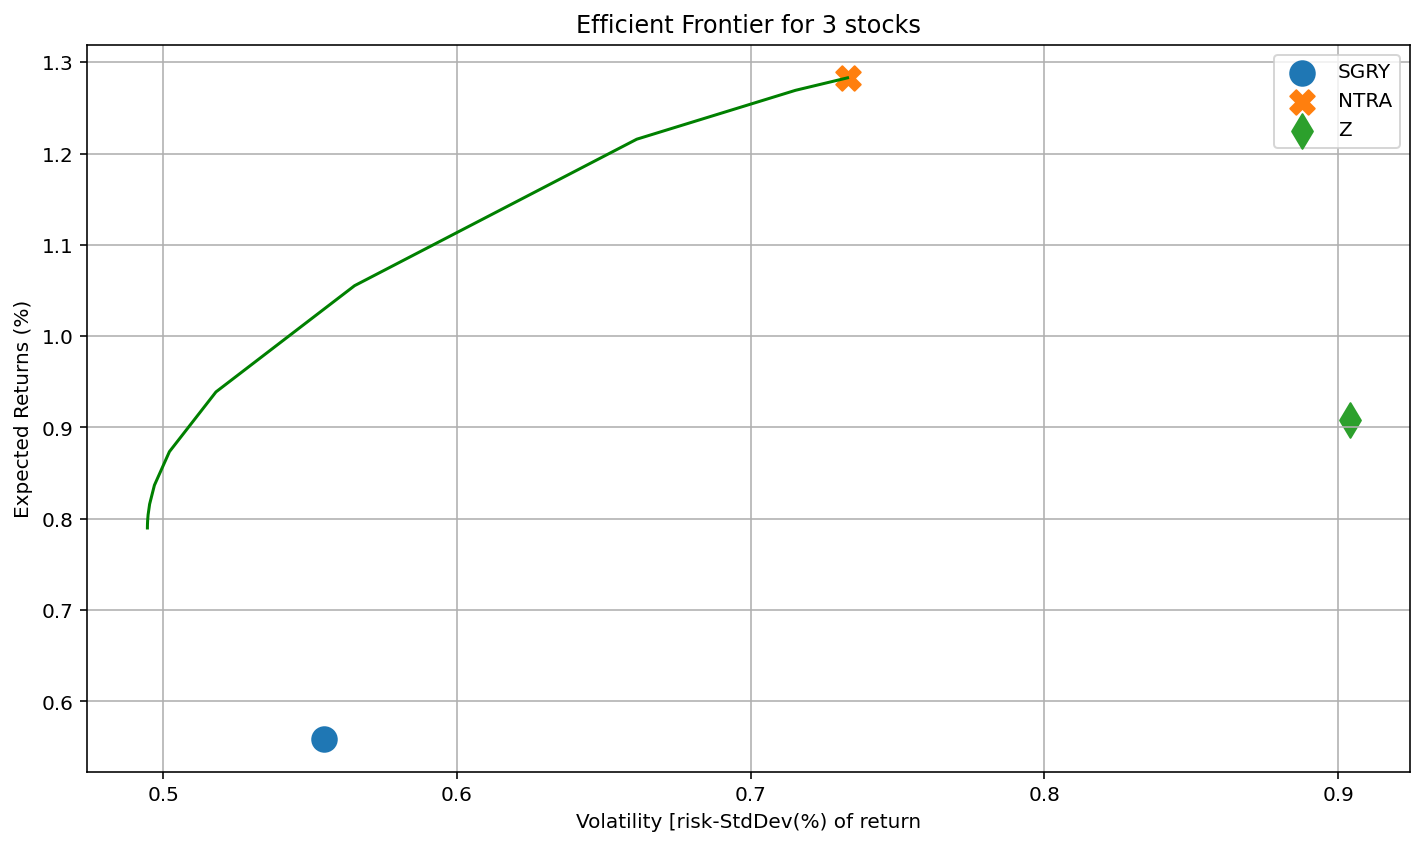

In [38]:
MARKS = ['o', 'X', 'd']

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(no_of_stocks):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), 
                 y=avg_returns[asset_index], 
                 marker=MARKS[asset_index], 
                 label=tickers[asset_index],
                 s=150)
ax.set(title='Efficient Frontier for 3 stocks',
       xlabel='Volatility [risk-StdDev(%) of return', 
       ylabel='Expected Returns (%)')
ax.legend(); plt.grid(True)
plt.tight_layout()
plt.show()